In [523]:
import pandas as pd
import numpy as np
import re

from collections import Counter
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.optim as torch_optim
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import models
import datetime

# from sklearn.preprocessing import OneHotEncoder
# import copy
# from imblearn.over_sampling import SMOTENC

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [624]:
#read raw features
X = pd.read_csv('result/46346_45.csv')
#read labels
y = pd.read_csv('data/y.csv')
#Combine features and labels
data = pd.merge(X, y, how='left', on='full_name')

/home/junliang/venvs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [625]:
data.shape

(46346, 46)

In [637]:
#display complete form 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [638]:
data.dtypes

full_name                  object
mirror_url                 object
archived                   object
disabled                   object
if_fork                    object
size                      float64
files                     float64
stars                     float64
watches                   float64
forks                     float64
recent_commits            float64
recent_added              float64
recent_deleted            float64
recent_contributors       float64
latest_commits             object
owner_type                 object
description                object
formats                    object
homepage                   object
license                    object
language                   object
commits                   float64
branches                  float64
releases                  float64
contributors              float64
topics                    float64
age                       float64
has_issues                 object
open_issues               float64
closed_issues 

In [639]:
#Ignore repos not found
found = ~data['info'].isin(["Not Found", "Repository access blocked", "Empty"])
data = data[found]
num_samples = len(data)
num_labeled = sum(data['Y'].notna())
print('Found %d data points, %d labeled, %d unlabeld.'% (num_samples, num_labeled, num_samples - num_labeled) )

Found 42837 data points, 350 labeled, 42487 unlabeld.


In [640]:
#count labels in classes
for i in range(4):
    print('%d samples in class %d' % (len(data[data['Y']==i+1]), i + 1))

115 samples in class 1
106 samples in class 2
65 samples in class 3
64 samples in class 4


In [980]:
data[data['full_name']=='julycoding/The-Art-Of-Programming-By-July']

,full_name,mirror_url,archived,disabled,if_fork,size,files,stars,watches,forks,recent_commits,recent_added,recent_deleted,recent_contributors,latest_commits,owner_type,description,formats,homepage,license,language,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,dependent_repositories,dependent_packages,repositories,people,followers,readme,info,Y,license_key,google,h2,links,words,book_in_name,book_in_desc,book_phrase,note_in_name,note_in_desc,study_in_name_desc,md_ratio,txt_ratio,pdf_ratio,doc_ratio,docx_ratio,ppt_ratio,pptx_ratio,epub_ratio,jpg_ratio,png_ratio,jpeg_ratio,gif_ratio,rar_ratio,zip_ratio,_ratio,pic_ratio,docu_ratio,code_ratio,recent_changed,latest_commits_num,latest_commits_avg,latest_commits_min
4,julycoding/The-Art-Of-Programming-By-July,NaN,False,False,False,27451.0,831.0,19203.0,1907.0,7003.0,0.0,0.0,0.0,0.0,"[740, 815, 846, 946, 1010, 1091, 1159, 1160, 1...",False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,"{'': 7, 'md': 87, 'png': 131, 'json': 1, 'yaml...",False,False,C,3633.0,1.0,0.0,99.0,0.0,2376.0,True,45.0,82.0,0.0,0.0,22.0,320.0,1.0,0.0,6.0,0.0,0.0,0.0,4.0,0.0,4.0,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,NaN,3.0,none,False,9,55,828,False,False,False,False,False,False,0.104693,0.0,0.0,0.0,0.0,0.0,0.0,0.001203,0.418773,0.157641,0.081829,0.067389,0.0,0.0,0.008424,0.725632,0.0,0.160048,0.0,10,1023.7,740


In [641]:
#fill NaN with 0
data = data.fillna(value = {'people': 0, 'followers': 0, 'open_issues': 0, 'closed_issues': 0, 
                            'open_issues_recent': 0, 'closed_issues_recent': 0, 'open_prs': 0, 
                            'closed_prs': 0, 'open_prs_recent': 0, 'closed_prs_recent': 0,
                            'recent_commits': 0, 'recent_contributors': 0, 'recent_added': 0, 'recent_deleted': 0})

#fill NaN with ''
data = data.fillna(value = {'readme': '', 'description': '', 'license': ''})

#fill NaN with {}
data = data.fillna(value = {'language': {}})

In [642]:
#make binary
data.loc[:, 'homepage'] = data['homepage'].notna()
data.loc[:, 'owner_type'] = data['owner_type'] == 'Organization'

In [643]:
#get license key
def license_counter(all_data, key):
    counter_dic = {}
    for item in all_data:
        val = item[key]
        counter_dic[val] = counter_dic.get(val, 0) + 1
    return counter_dic

def license_key(license):
    if license:
        return eval(license)['key']
    else:
        return license
    
def get_license_key(data):
    licenses = [eval(license) for license in data['license'].values if license]
    key_counter = license_counter(licenses, 'key')
    license_count = pd.DataFrame.from_dict({'key':list(key_counter.keys()), 'count':list(key_counter.values())})

    #find keys that only appear once
    least_license_key = license_count[license_count['count'] < data.shape[0] * 5e-3]['key'] 
    data['license_key'] = data['license'].apply(license_key)
    is_least_license = data['license_key'].isin(least_license_key)
    
    #label least keys as 'other'
    data.loc[is_least_license, ['license_key']] = 'other'

In [644]:
data.shape

(42837, 46)

In [645]:
# licenses = [eval(license) for license in data['license'].values if license]
# key_counter = license_counter(licenses, 'key')
# license_count = pd.DataFrame.from_dict({'key':list(key_counter.keys()), 'count':list(key_counter.values())})
# license_count

In [646]:
get_license_key(data)

In [647]:
set(data['license_key'])

{'', 'apache-2.0', 'gpl-2.0', 'gpl-3.0', 'lgpl-3.0', 'mit', 'other'}

In [648]:
data['license_key'] = data['license_key'].apply(lambda x: 'none' if not x else x)

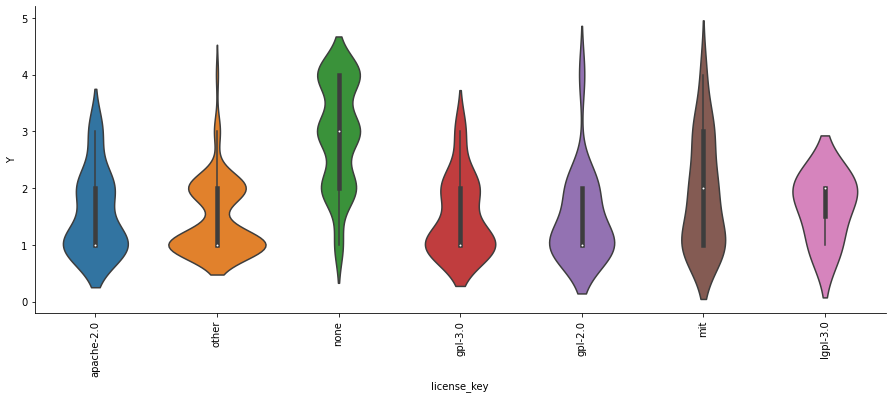

In [509]:
g = sns.catplot(x="license_key", y="Y", kind='violin', data=data, aspect=2.5)
g.set_xticklabels(rotation=90)

In [649]:
data['license'] = data['license'].apply(lambda x: True if x else False)

In [982]:
def count_words(x):
    """Find document features and use Regex to find keywords
    """
    name = x['full_name'].split('/')[1].replace('-', ' ').replace('_', ' ').lower()
    desc = x['description'].lower()
    rm = x['readme'].lower()
    #s is combination of description and readme
    s = (desc + '\n' + rm).lower()
    #'\xfe' is the char to substitute '\n'
    s = s.replace('\xfe', '\n')
     
    #find codes from code.google.com
    all_results = re.search('code.google.com', s)
    google = True if all_results else False
    s = re.sub('code.google.com', '', s)
    
    #find all links
    URL = r'https?:\/\/[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b[-a-zA-Z0-9()@:%_\+.~#?&//=]*'
    all_results = re.findall(URL, s)
    links = len(all_results)
    
    #remove URL
    s = re.sub(URL, '', s)
    
    #count number of words (ignore non-word char)
#     s = re.sub(r'\W+', ' ', s)
    all_results = re.findall('\w+', s)
    words = len(all_results)
    
    #remove codes
    s = re.sub('```((?!```)[\s\S])*```', '', s)
    s = re.sub('<pre>([\s\S])*</pre>', '', s)
    
    #find all heading 1
    all_results = re.findall('^= (?=.*[a-zA-Z\d]+)', s, re.MULTILINE)
    if not all_results:
        #find == under alphanumeric
        all_results += re.findall('^(?=.*[a-zA-Z0-9]).*\n[=]+\n', s, re.MULTILINE)
        # find #
        all_results += re.findall('^# ', s, re.MULTILINE)
    h1 = len(all_results) - 1
    
    #find all heading 2
    #find == followed by alphanumeric
    all_results = re.findall('^== (?=.*[a-zA-Z\d]+)', s, re.MULTILINE)
    if not all_results:
        #find -- under alphanumeric
        all_results += re.findall('^(?=.*[a-zA-Z0-9]).*\n[-]+\n', s, re.MULTILINE)
        # find ##
        all_results += re.findall('^## ', s, re.MULTILINE)
    h2 =  len(all_results)
    
    #find all heading 3
    #find == followed by alphanumeric
    all_results = re.findall('^=== (?=.*[a-zA-Z\d]+)', s, re.MULTILINE)
    if not all_results:
        #find __ under alphanumeric
        all_results += re.findall('^(?=.*[a-zA-Z0-9]).*\n[_]+\n', s, re.MULTILINE)
        # find ###
        all_results += re.findall('^### ', s, re.MULTILINE)
    h3 = len(all_results)
    
    if h1 > 0:
        h2, h3 = h1, h2
    
    #In name, find "book(s)" not following "face", "note"
    all_results = re.findall(r'(?<!face|note)books?', name)
    book_in_name = len(all_results) 
    
    #In description, find "book(s)""
    all_results = re.findall(r'[\w]*books?\b', desc)
    all_results += re.findall(r'书籍?', desc)
    #rule out "faebook" and "notebook"
    book_in_desc = len([x for x in all_results if 'facebook' not in x and 'notebook' not in x])

    #In readme, find "book(s)" following "a", "this", "these", "the"
    all_results = re.findall(r'(?:a|this|these|the) books?\b', rm)
    #find "book(s)" followed by "about"
    all_results += re.findall(r'books? about', rm)
    all_results += re.findall(r'[本|此]书', rm)
    book_phrase = len(all_results)
    
    #if "book" is followed by manag|read|app|tool|edit|shel|scan|print|find, ignore all "books" in the repo
    all_results = re.findall(r'\be?books?[\s_-]*(?:manag|read|app|tool|edit|shel|scan|print|find)', name + '\n' + s)
    if all_results:
        book_in_name, book_in_desc, book_phrase = 0, 0, 0
    
    #In name, find "note" not followed by "book", Find "cheatsheet"
    all_results = re.findall(r'note(?!book)', name)
    all_results += re.findall(r'cheat[\s_-]*sheet|summar(?:y|ies)', name)
    note_in_name = len(all_results) 
        
    #In content, find "note(s)" with "\b", not followed by ":", "that", not following "please"
    all_results = re.findall(r'\b(?<!please)(?<!\s)[\s]*notes?[\s]*(?!\s|that|\:)\b', desc)
    all_results += re.findall(r'cheat[\s_-]*sheet|summar(?:y|ies)', desc)
    #"note" in Chinese
    all_results += re.findall(r'笔记|整理|资料', desc)
    note_in_desc = len(all_results)

    #If there are "note pad", "note tak", "release note", ignore all findings.
    all_results = re.findall(r'\bnotes?[\s-]*(?:pad|tak)', name + '\n' + s)
    all_results += re.findall(r'release[\s-]*notes?\b', name + '\n' + s)
    if all_results:
        note_in_name, note_in_desc = 0, 0

    
    #In name and content, find "study", "tutotial". "HW" is used in "hardware", so ignore it.
    all_results = re.findall(r'study|tutorial|教程', name + desc)
    #In name and content, find "learn" not following 'machine','deep','reinforcement','supervised', 'statistical'
    exclude = ['machine','deep','reinforcement','supervised', 'statistical','[\s-]']
    rx = ''.join(['(?<!' + ex + ')' for ex in exclude]) + '[\s-]*learn'
    exclude = ['机器','深度','强化','监督式','监督','统计']
    rx = ''.join(['(?<!' + ex + ')' for ex in exclude]) + '学习'
    all_results += re.findall(rx, name + desc)
    study_in_name_desc = len(all_results) 
    
    #Find positive phrases followed by "for", "of", "on", "about"
#     all_results = re.findall(r'notes? (?:for|of|on|about)', s)
#     note_phrase = max(0, len(all_results) - note_in_content)
    
# #     print(all_results)
                             

    
    
    return (google, h2, h3, links, words, book_in_name, book_in_desc, book_phrase, note_in_name, note_in_desc, study_in_name_desc)

In [987]:
#add document features
new_columns = pd.DataFrame(data.apply(count_words, axis=1))
count_words_features = ['google', 'h2', 'h3', 'links', 'words', 'book_in_name', 'book_in_desc', 'book_phrase', 
                    'note_in_name', 'note_in_desc', 'study_in_name_desc']
data[count_words_features] = pd.DataFrame(new_columns[0].tolist(), index= data.index)

In [979]:
book_repo = data[data['book_in_name'] | data['book_in_desc'] | data['book_phrase']]
book_repo.shape

(391, 79)

In [961]:
s = data.loc[14636]['readme']
s = s.replace('\xfe', '\n')
s = re.sub('```((?!```)[\s\S])*```', '', s)
URL = r'https?:\/\/[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b[-a-zA-Z0-9()@:%_\+.~#?&//=]*'
all_results = re.findall(URL, s)
links = len(all_results)
print(all_results)

['https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb3.gif', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb3.gif', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb1.gif', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb1.gif', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb5.gif', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/gaiandb5.gif', 'http://www.usukita.org/files/Page238.pdf', 'http://db.apache.org/derby/docs/10.5/ref/', 'http://publib.boulder.ibm.com/infocenter/db2luw/v9/index.jsp?topic=%2Fcom.ibm.db2.udb.admin.doc%2Fdoc%2Fr0001934.htm', 'http://poi.apache.org/download.html', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/s_dashboard-connect.png', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/s_dashboard-topo.png', 'https://github.com/gaiandb/gaiandb/blob/master/doc/UserDocs/images/

In [946]:
count_words(data.loc[6275])

(False, 9, 104, 2135, 0, 0, 0, 1, 1, 0)

In [939]:
re.findall(r'cheat[^\d\w]*sheet', 'cheat3sheet')
re.findall(r'cheat[\s_-]*sheet|summar(?:y|ies)', 'summaries')
# re.findall(r'\b(?<!please)(?<!\s)[\s]*notes?[\s]*(?!\s|that|\:)\b', 'please notes d that')
# URL = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
# re.findall(URL, ' rrr/5.txt')
# \b(?<!please)(?<!\s)[\s]*

['summaries']

In [636]:
data[labeled & (data['full_name']=='audreyr/favicon-cheat-sheet')]

,full_name,mirror_url,archived,disabled,if_fork,size,files,stars,watches,forks,recent_commits,recent_added,recent_deleted,recent_contributors,latest_commits,owner_type,description,formats,homepage,license,language,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,dependent_repositories,dependent_packages,repositories,people,followers,readme,info,Y
6275,audreyr/favicon-cheat-sheet,NaN,False,False,False,329.0,3.0,9447.0,296.0,407.0,1.0,4.0,1.0,1.0,"[127, 390, 1219, 1489, 1534, 1578, 1620, 1626,...",User,Obsessive cheat sheet to favicon sizes/types. ...,"{'ai': 1, '': 1, 'rst': 1}",NaN,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",NaN,91.0,1.0,0.0,22.0,0.0,2532.0,True,30.0,9.0,0.0,0.0,15.0,26.0,2.0,0.0,6.0,0.0,0.0,0.0,NaN,NaN,1.0,favicon-cheat-sheetþ===================þþA pai...,NaN,3.0


In [389]:
count_words(data.loc[14636])

1


(False, 78, 34, 34990, 0, 0, 0, 0, 0, 0)

In [27]:
# s = data.loc[6324, ['readme']].values[0]
# # s = 'note book'
# all_results = re.findall(r'(?<!/)ebooks?', s)
# all_results += re.findall(r'(?<![/e])books?', s)

# print(all_results)
# all_results = re.findall(r'\b(?<![\w_\/=?.-])[\w_.-]*((?<!please )\bnotes?)(?:[^\w:\s]+|[\s]+(?!that|-|\s))', 'please ./ / :notes: . -that  note: book')

# print(all_results)
# all_results = re.findall(r'(?<!face|note)books?', s)
# print(all_results)

# all_results = re.findall(r'cheat[\b]*sheet|summar(?:y|ies)|study','cheat sheet ')
# print(all_results)
# all_results = re.findall(r'[这|此]书', '这本此书')
# all_results = re.findall(r'release[\s-]*notes?\b', 'release notes note  takpad')
# print(all_results)
# exclude = ['machine','deep','reinforcement','supervised', '[\s-]']
# rx = ''.join(['(?<!' + ex + ')' for ex in exclude]) + '[\s-]*learn'
# all_results = re.findall(rx, 'deep learning ')
# print(all_results)

In [652]:
def lower_key(dic):
    """make formats lowercase
    :params: format dictionary
    """
    new = {}
    for key in dic:
        new[key.lower()] = new.get(key.lower(), 0)+ dic[key]
    return new

#make format lowercase
data['formats'] = data.apply(lambda x: lower_key(eval(x['formats'])), axis=1)

In [653]:
def format_counter(all_data):
    """Count all formats"""
    counter_dic = {}
    i=0
    for dic in all_data:
        for key in dic:
            try:
                new_key = key.lower()
            except:
                new_key = key
            counter_dic[new_key] = counter_dic.get(new_key, 0) + dic[key]
    return counter_dic

In [654]:
#formats counter dictionary
formats = [format_ for format_ in data['formats'].values if format_]
formats_count = format_counter(formats)
# formats_count

In [655]:
def document_frequency(formats):
    """Count formats document frequency"""
    format_document_frequency = {}
    for dic in formats:
        for format_ in dic:
            format_document_frequency[format_] = format_document_frequency.get(format_, 0) + 1
    return format_document_frequency

In [656]:
format_document_frequency = document_frequency(formats)
# format_document_frequency

In [35]:
def sort_plot(data):
    """plot dictionary in sorted order"""
    counts = [(data[i], i) for i in data]
    counts = sorted(counts, reverse=True)
    y = [num for num, name in counts]
    plt.bar(np.arange(len(y)), np.log(y)/np.log(10))
    return counts

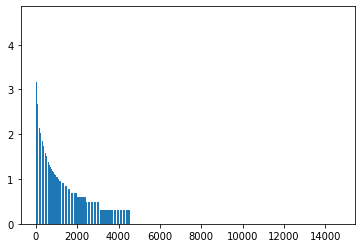

In [36]:
_ = sort_plot(format_document_frequency)

In [657]:
#minority formats
minor = set(fmt for fmt in format_document_frequency if format_document_frequency[fmt]<5)

In [658]:
print(len(format_document_frequency))
print(len(minor))

14715
12714


In [659]:
def ignore_minor(dic):
    """Transform minor to '' """
    for fmt in dic:
        if fmt in minor:
            dic[''] = dic.get('', 0) + dic[fmt]

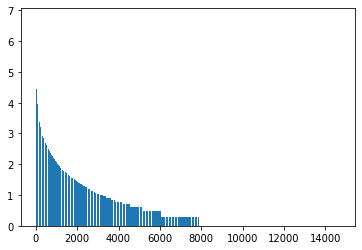

In [40]:
format_value = sort_plot(formats_count)

In [41]:
# books_id = [4, 104, 138, 140, 147, 148, 150, 151, 153, 154, 156,158,160,]
# books = data.loc[data.index.isin(books_id)]
# books

In [42]:
# idx = 9
# dic = data['formats'][idx]
# l = [(dic[key], key) for key in dic]#.values[0]
# l.sort(reverse=True)
# print(data['files'][idx])
# print(l)

In [660]:
#select formats as features
selected_formats = ['md','txt', 'pdf', 'doc','docx', 'ppt', 'pptx', 'epub', 'jpg','png','jpeg','gif','rar', 'zip', '']

In [661]:
#aggregate formats in to picture, document, rar, code
for format_ in  selected_formats:
    data[format_ + '_ratio'] = data.apply(lambda x: x['formats'].get(format_, 0)/x['files'], axis=1)
    
pic_formats = ['jpg', 'png', 'jpeg', 'gif']
docu_formats = [ 'pdf', 'doc', 'docx', 'ppt', 'pptx']
rar_formats = ['rar', 'zip']

data['pic_ratio'] = data[[format_ + '_ratio' for format_ in pic_formats]].sum(axis=1)
data['docu_ratio'] = data[[format_ + '_ratio' for format_ in docu_formats]].sum(axis=1)
data['rar_ratio'] = data[[format_ + '_ratio' for format_ in rar_formats]].sum(axis=1)
data['code_ratio'] = data.apply(lambda x: 1 - x[['md_ratio', 
    'txt_ratio', 'epub_ratio', 'pic_ratio', 'docu_ratio', 'rar_ratio', '_ratio']].sum(), axis=1)

In [662]:
ratios = ['md_ratio', 'txt_ratio', 'epub_ratio', 'pic_ratio', 'docu_ratio', 'rar_ratio', 'code_ratio']
dump_formats = pic_formats + docu_formats + rar_formats
dump_format_features = [format_ + '_ratio' for format_ in selected_formats if format_ in dump_formats]



In [64]:
# data_selected = data.drop(dump_format_features + ['mirror_url', 'archived', 'disabled', 'if_fork'], axis=1)

In [55]:
# data.loc[:5, ['full_name', 'description'] + processed_formats + new_column_names]

In [48]:
# labeled_not_book = data.loc[~data.index.isin(books_id) & data['Y'].notna(), ['full_name', 'description'] + new_formats]

In [49]:
# labeled_not_book#.loc[labeled_not_book['code_ratio']<0.5]

In [50]:
# not_books = data.loc[~data.index.isin(books_id), ['full_name', 'description'] + new_formats]
# not_books[(not_books['code_ratio']<0.8) & (not_books['book_in_desc']>0)]

In [51]:
# not_books.loc[not_books['code_ratio']<0.2]

In [52]:
# not_books.head()

In [996]:
to_bool = ['has_issues', 'book_in_name', 'book_in_desc', 'book_phrase', 'note_in_name', 'note_in_desc', 'study_in_name_desc']
data = data.astype({name : bool for name in to_bool})
data = data.astype({'license_key': 'category'})

# for i in range(len(data.columns)):
#     if data[data.columns[i]].dtypes == 'float64' and data.columns[i] != 'Y':
#         data = data.astype({data.columns[i]: int})

In [664]:
data['recent_changed'] = data['recent_added'] + data['recent_deleted']
data['latest_commits'] = data['latest_commits'].apply(lambda x: eval(x))
max_time = (datetime.datetime.now() - datetime.datetime.strptime('1980-01-01','%Y-%m-%d')).days
data['latest_commits_num'] = data['latest_commits'].apply(lambda x: len(x))
data['latest_commits_avg'] = data['latest_commits'].apply(lambda x: np.mean(x))
data['latest_commits_min'] = data['latest_commits'].apply(lambda x: x[0])

In [997]:
to_drop = dump_format_features 
#     + ['mirror_url', 'archived', 'disabled', 'if_fork'] + \
#     ['full_name','description','readme', 'license_key', 'language','info', 'dependent_packages', 'formats', 
#      'repositories', 'recent_added', 'recent_deleted', 'latest_commits']
X_y = data.drop(to_drop, axis=1)

In [998]:
X = X_y.drop(['Y'], axis=1)

In [999]:
X.to_csv('result/X.csv', index=False)

In [995]:
data.shape

(42837, 80)

In [438]:
embedded_cols = {n: len(col.cat.categories) for n,col in X.items() if isinstance(col.dtypes, pd.CategoricalDtype)}
embedded_cols

{'license_key': 15}

In [439]:
labeled = X_y['Y'].notna()
X_y_labeled = X_y.loc[labeled]
y = X_y[labeled]['Y'] - 1 

In [440]:
col_id = {col: i for i, col in enumerate(X_y_labeled.columns)}
categorical = [col_id[col] for col in embedded_cols]
numerical = [i for i in range(len(X_y_labeled.columns)) if i not in categorical]

In [128]:
sm = SMOTENC(random_state=None, categorical_features=categorical)
X_y_labeled, y = sm.fit_resample(X_y_labeled, y)

In [307]:
feature = 'size'
feature_tree = feature + '_tree'

In [308]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

feature_ = X_y_labeled[feature].values.reshape(-1, 1)
tree_model = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=8)
tree_model.fit(feature_, y)
X_y_labeled[feature_tree] = tree_model.predict_proba(feature_)[:,1] 


In [286]:
tree_model.predict_proba(feature_)

array([[0.66666667, 0.        , 0.33333333, 0.        ],
       [0.66666667, 0.        , 0.33333333, 0.        ],
       [0.66666667, 0.        , 0.33333333, 0.        ],
       ...,
       [0.        , 0.21637427, 0.23976608, 0.54385965],
       [0.        , 0.21637427, 0.23976608, 0.54385965],
       [0.        , 0.21637427, 0.23976608, 0.54385965]])

In [287]:
tree_value = X_y_labeled[[feature,feature_tree,'Y']]

In [288]:
tree_value[feature_tree].unique()

array([0.        , 0.25688073, 0.32258065, 0.21637427, 0.37254902,
       0.29411765, 0.14285714])

In [289]:
# fig = plt.figure()
# fig = X_y_labeled.groupby(['size_tree'])['Y'].mean().plot()
# fig.set_title('Monotonic relationship between discretised Age and target')
# fig.set_ylabel('Y')

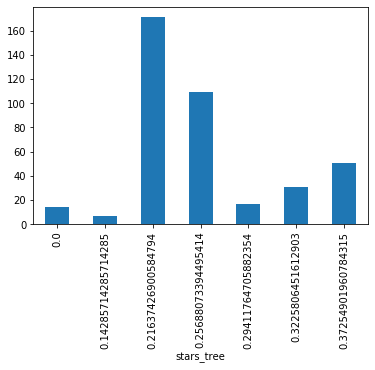

In [290]:
X_y_labeled.groupby(feature_tree)['Y'].count().plot.bar()

In [291]:
limit = X_y_labeled.groupby(feature_tree)[feature]
pd.concat( [limit.min(), limit.max()], axis=1)

,stars,stars
stars_tree,,
0.000000,354,32981
0.142857,137,198
0.216374,0,0
0.256881,438,9111
0.294118,4,8
0.322581,11,129
0.372549,1,3


In [309]:
thresholds = [point for point in tree_model.tree_.threshold if point != -2.0]
# thresholds.sort()

In [310]:
thresholds

[2032.5, 126.0, 423022.5, 3777.5, 1224.0, 1001.5, 430.5]

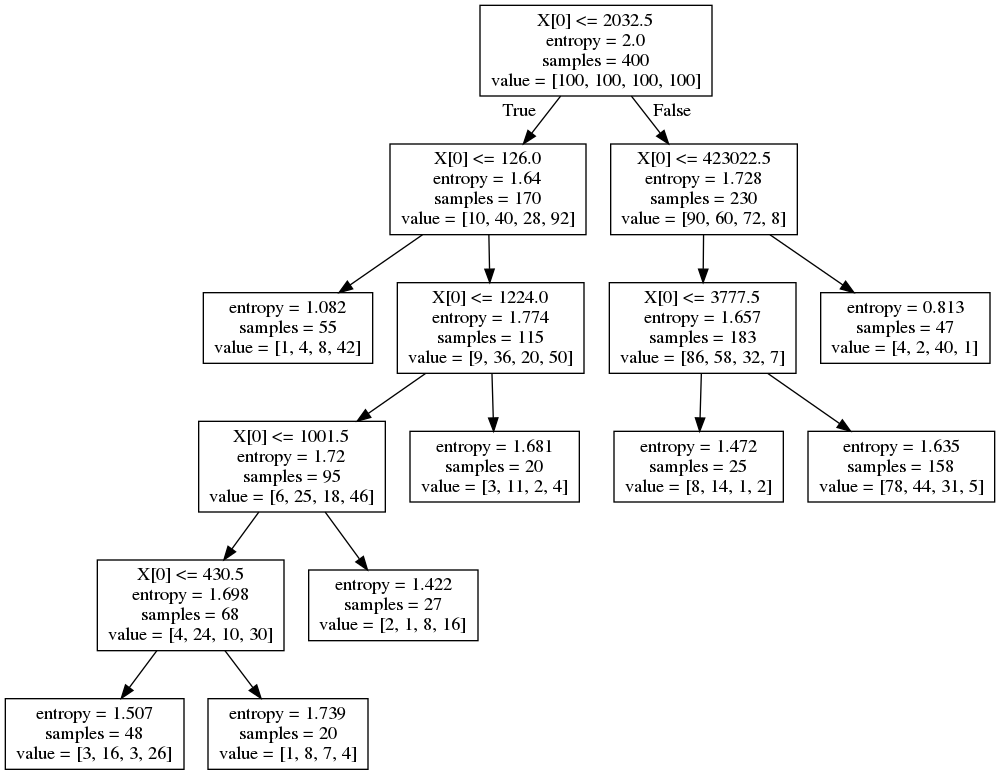

In [311]:

from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


with open("tree/tree.dot", 'w') as dotfile:
    dot_data = tree.export_graphviz(tree_model, out_file = None, )
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

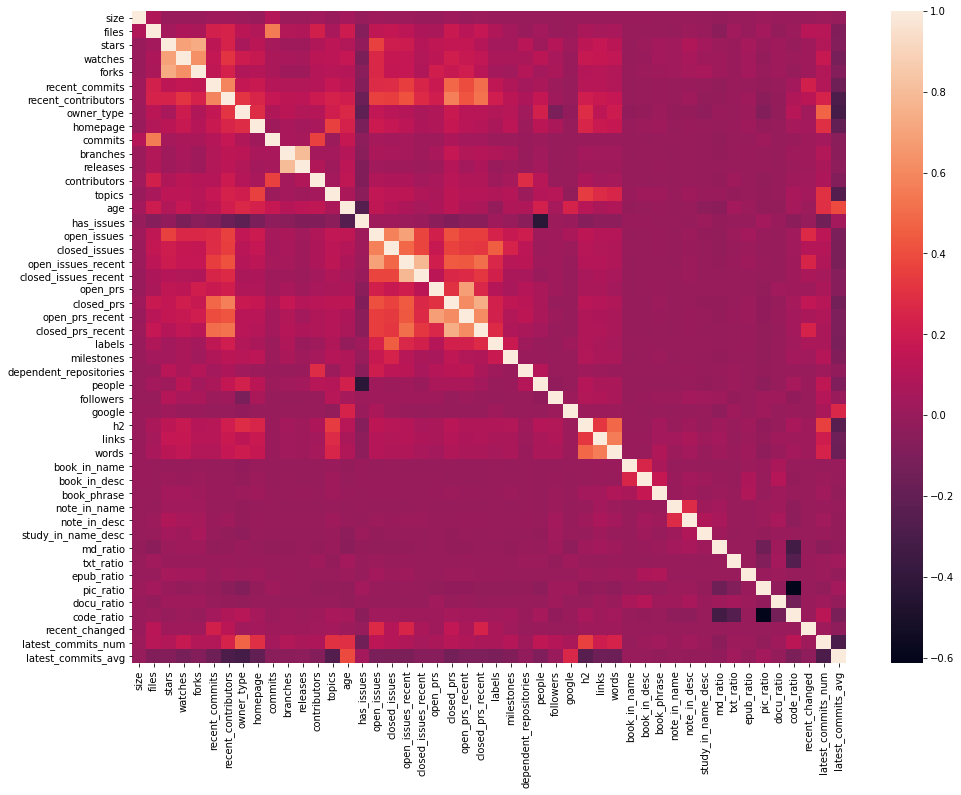

In [401]:
corr = X.corr()

# show heapmap of correlations
fig, ax = plt.subplots(figsize=(16,12))
ax = sns.heatmap(corr)

In [442]:
X_labeled_w_y = X_y[labeled]
X_labeled = X_labeled_w_y.drop(['Y'], axis=1)
dtypes = X_labeled_w_y.dtypes
columns = X_labeled_w_y.columns
# num_cat = sum([1 for name in columns if isinstance(dtypes[name], CategoricalDtype)])
# num_numerical = len(columns) - num_cat
# print(num_cat, num_numerical)
dtypes

size                         int64
files                        int64
stars                        int64
watches                      int64
forks                        int64
recent_commits               int64
recent_contributors          int64
owner_type                    bool
homepage                      bool
commits                      int64
branches                     int64
releases                     int64
contributors                 int64
topics                       int64
age                          int64
has_issues                    bool
open_issues                  int64
closed_issues                int64
open_issues_recent           int64
closed_issues_recent         int64
open_prs                     int64
closed_prs                   int64
open_prs_recent              int64
closed_prs_recent            int64
labels                       int64
milestones                   int64
dependent_repositories       int64
people                     float64
followers           

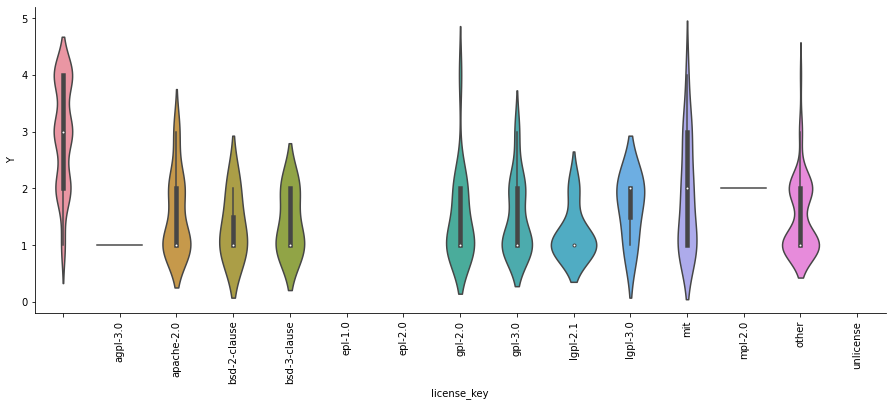

In [443]:
g = sns.catplot(x="license_key", y="Y", kind='violin', data=X_labeled_w_y, aspect=2.5)
g.set_xticklabels(rotation=90)

In [313]:
data.loc[data.h2>100].index

Int64Index([2250, 6645, 8636, 10114, 10226, 12466], dtype='int64')

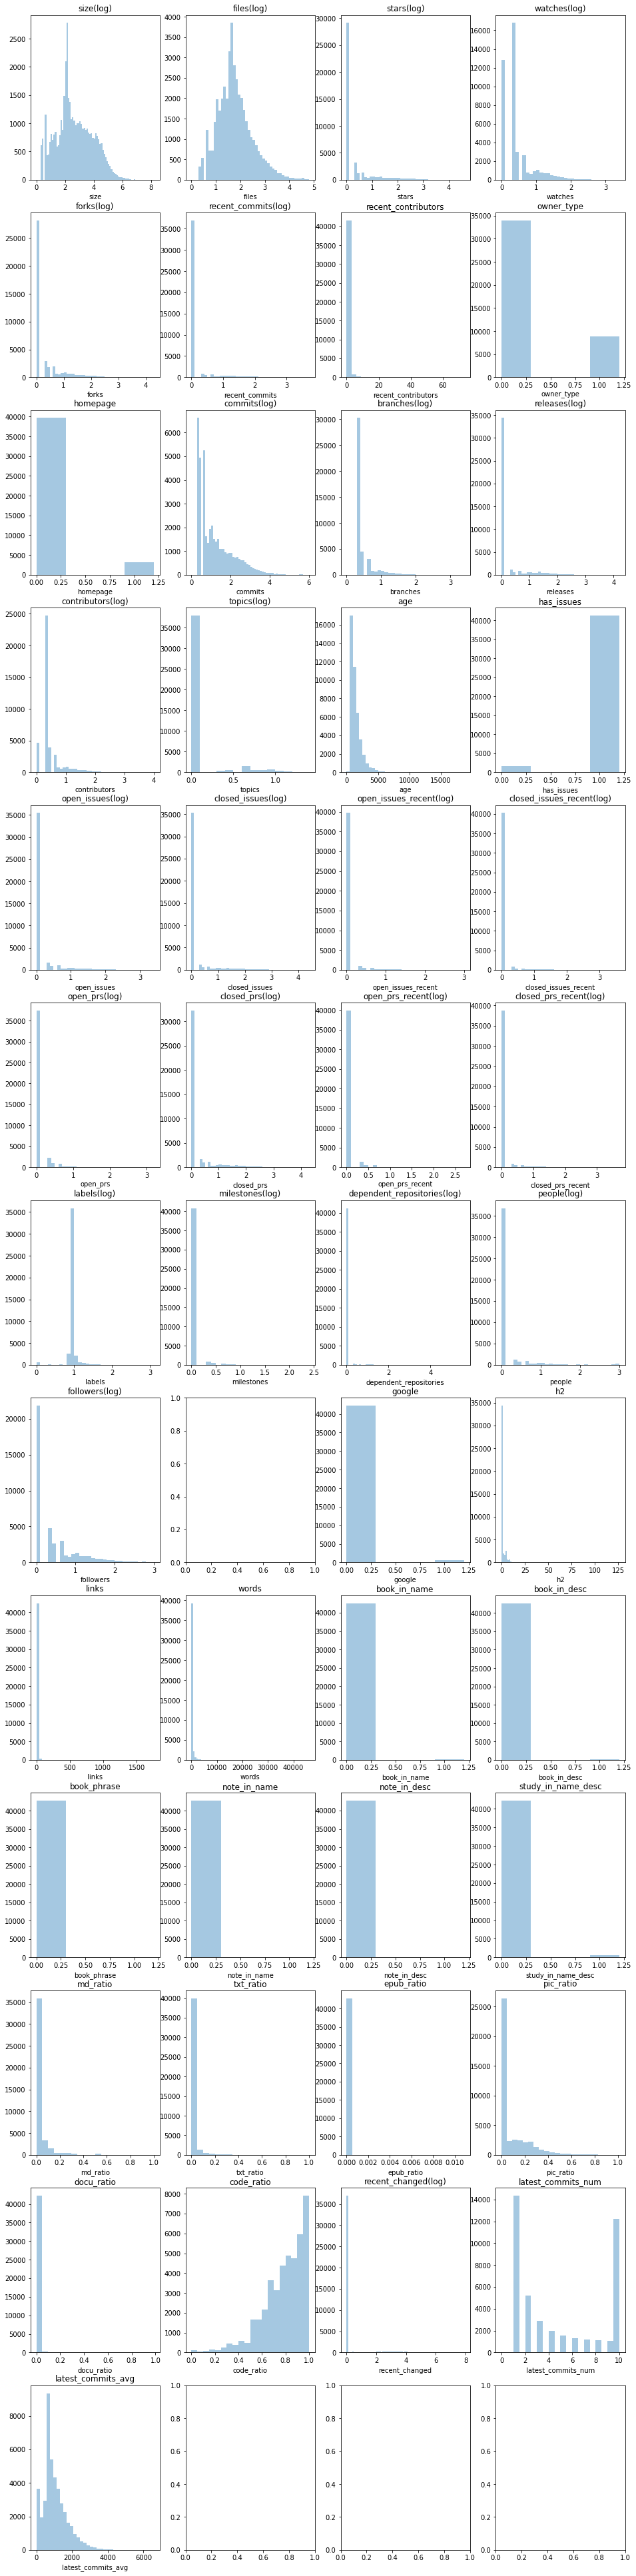

In [420]:
normal_plot = [ 'recent_contributors', 'age', 
               'latest_commits_num', 'latest_commits_avg'] + \
    [name for name in count_words_features if name != 'google'] + ratios
# bin_plot = [name for name in columns if dtypes[name] == bool]
f, axes = plt.subplots(13, 4, figsize=(16, 70))
for i in range(len(X_labeled.columns)):
# f, axes = plt.subplots(1, 4, figsize=(16, 4))
    column = X_labeled.columns[i]
    if column in [X_y.columns[i] for i in categorical]:
        continue
    if_log = 0
    if_bin = dtypes[column] == bool
    if not if_bin and column not in normal_plot:
        if_log = 1
        
#     for j in range(1,5):
    d = X[X[column].notna()][column]
    if if_log:
        d = np.log(d+1) / np.log(10) 
        width = 0.1
    elif if_bin:
        width = 0.3
    else:
        width = X_labeled[column].values.max()/20
    bins = np.arange(0, d.values.max() + width, width)
#             pass
    if not len(bins):
        bins = [0]
    g = sns.distplot(d, kde=False, ax=axes[i//4, i%4], bins=bins)
    #     g.set(xscale='log')
    #     plt.xscale('log')

  
    title = column + ('(log)' if if_log else '')
    g.set_title(title)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


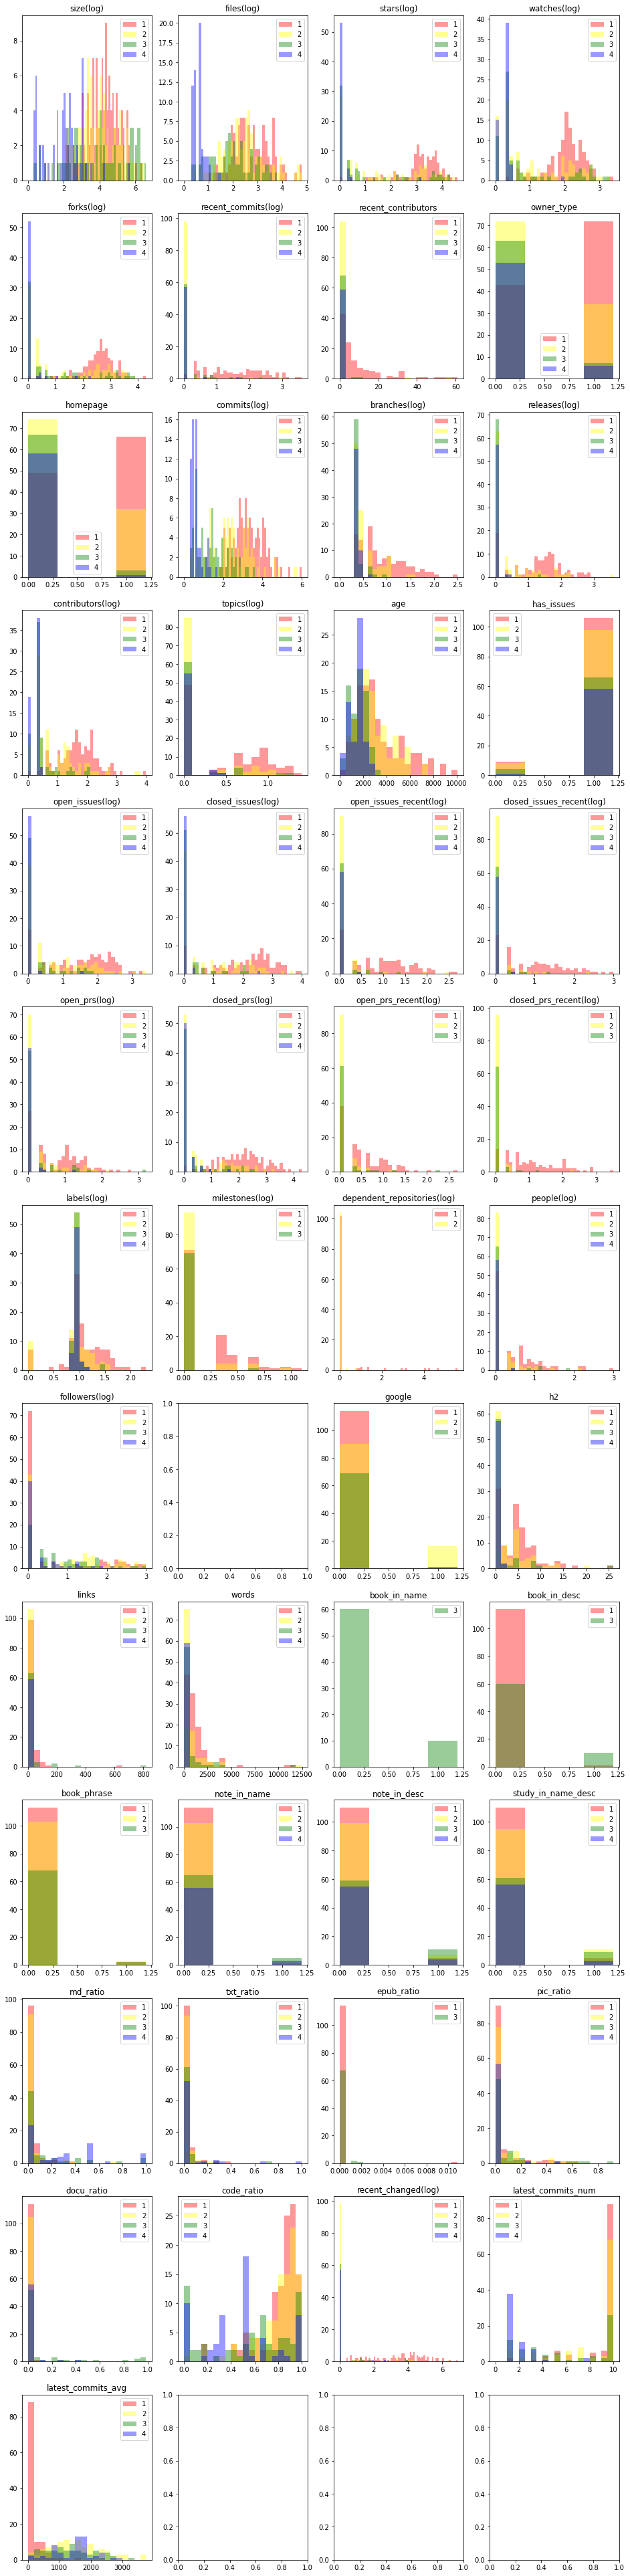

In [421]:
colors = ['red', 'yellow', 'green', 'blue']
f, axes = plt.subplots(13, 4, figsize=(16, 70))
for i in range(len(X_labeled.columns)):
# f, axes = plt.subplots(1, 4, figsize=(16, 4))
    column = X_labeled.columns[i]
    if column in [X_y.columns[i] for i in categorical]:
        continue
    if_log = 0
    if_bin = dtypes[column] == bool
    if not if_bin and column not in normal_plot:
        if_log = 1
        
    for j in range(1,5):
        d = X_labeled.loc[(X_y_labeled['Y']==j),[column]]
        if if_log:
            d = np.log(d+1) / np.log(10) 
            width = 0.1
        elif if_bin:
            width = 0.3
        else:
            width = X_labeled[column].values.max()/20
        bins = np.arange(0, d.values.max() + width, width)
        if not len(bins):
            bins = [0]
        g = sns.distplot(d, label=j, kde=False, ax=axes[i//4, i%4], bins=bins, color=colors[j-1])
    #     g.set(xscale='log')
    #     plt.xscale('log')
#         for k in range(len(thresholds)):
#             g.axvline(np.log(thresholds[k]+1)/ np.log(10) , 0, (8-k)/10)
        
        g.legend()
    title = column + ('(log)' if if_log else '')
    g.set_title(title)



In [303]:
data[(data['stars']>1000) & (data['Y']==3)]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book
4,julycoding/The-Art-Of-Programming-By-July,27451,19203,1907,7003,False,False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,False,,3,C,"{'': 1, 'md': 1}",3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,0,4,0,4,NaN,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,3.0,,False,9,55,1286,0
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,False,1,7,272,2


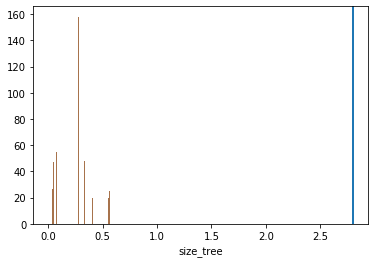

In [232]:
d = X_y_labeled['size_tree']
bins = np.arange(0, d.values.max() + 0.01, 0.01)
for j in range(1,5):
    g=sns.distplot(d, label=j, kde=False, bins=bins)
    plt.axvline(2.8, )

In [1704]:
X_labeled[X['Y']==3]

/home/yjl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,size,stars,watches,forks,owner_type,homepage,files,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,repositories,people,followers,license_key,google,h2,links,words,book,issues,prs,issues_recent,prs_recent,issue_pr,issue_pr_recent
4,27451,19203,1907,7003,False,False,3,3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,4,0,4,0,False,9,55,1286,0,127,342,0,1,469,1
104,5986,18806,1671,3270,False,True,17,243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,86,0,2,2,False,1,7,272,2,63,91,1,1,154,2
128,80,0,1,0,False,False,4,44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,20,0,1,0,False,0,0,9,0,4,0,0,0,4,0
134,24996,5,0,0,False,False,7,2,1,0,1,0,1292,True,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,10,0,59,0,False,0,3,42,0,1,0,0,0,1,0
138,1623614,0,1,0,False,False,18,3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,102,0,10,0,False,0,0,17,2,0,0,0,0,0,0
139,358681,1,2,0,False,False,13,157,1,0,1,0,2306,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,4,0,1,0,False,0,2,502,0,0,0,0,0,0,0
140,591903,50,6,19,False,False,13,27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,18,0,28,0,False,0,0,14,2,0,0,0,0,0,0
141,2070000,0,1,0,False,False,22,258,1,0,1,0,2634,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,19,0,2,0,False,0,0,4,0,0,0,0,0,0,0
144,343053,2,3,0,False,False,16,104,1,0,2,0,2211,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,35,0,56,0,False,0,0,7,0,0,0,0,0,0,0
147,536042,22,5,21,False,False,5,8,1,0,1,0,777,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,50,0,4,0,False,0,0,3,0,0,0,0,0,0,0


In [1644]:
embedded_col_names = embedded_cols.keys()
embedded_col_ids = [col_id[name] for name in embedded_cols]
n_cont = len(X_labeled.columns) - len(embedded_cols)
print('There are %d numerical columns' % n_cont)

There are 37 numerical columns


In [1645]:
col_id = {col: i for i, col in enumerate(X_labeled.columns)}
categorical = [col_id[col] for col in embedded_cols]
numerical = [i for i in range(len(X_labeled.columns)) if i not in categorical]

In [1646]:
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

[(18, 9)]

In [1412]:
sm = SMOTENC(random_state=None, categorical_features=categorical)
X_labeled, y = sm.fit_resample(X_labeled, y)

### Pytorch Dataset

In [1413]:
class ShelterOutcomeDataset(Dataset):
    def __init__(self, X, y, embedded_col_names):
        X = X.copy()
        
        self.X1 = X[:,categorical].copy().astype(np.int64) #categorical columns
        
        self.X2 = X[:,numerical].copy().astype(np.float64) #numerical columns
#         print(self.X1.shape, self.X2.shape, X.shape)
        self.y = y.values
        self.X1 = torch.tensor(self.X1)
        self.X2 = torch.tensor(self.X2).double()
        
        self.y = torch.tensor(self.y).long()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [1457]:
# import random


# train_index = np.random.choice(X_labeled.index, size=int(0.8 * len(X_labeled)), replace=False)

# X_train_ = X_labeled.loc[train_index]
# y_train_ = y[train_index]

# X_test = X_labeled.drop(train_index)
# y_test = y.drop(train_index)

# train_index = np.random.choice(X_train_.index, size=int(0.8 * len(X_train_)), replace=False)

# X_train = X_train_.loc[train_index]
# y_train = y_train_[train_index]

# X_val = X_train_.drop(train_index)
# y_val = y_train_.drop(train_index)

X_train_ = [0,0,0,0]
X_test = [0,0,0,0]
y_train_ = [0,0,0,0]
y_test = [0,0,0,0]
for i in range(4):
    class_i = y[y == i].index
    X_labeled_i, y_labeled_i = X_labeled.loc[class_i], y[class_i]
    X_train_[i], X_test[i], y_train_[i], y_test[i] = train_test_split(X_labeled_i, y_labeled_i, test_size=0.2)

X_train_, X_test, y_train_, y_test = map(pd.concat, (X_train_, X_test, y_train_, y_test))
# X_train_, X_test, y_train_, y_test = model_selection.train_test_split(X_labeled, y, test_size=0.2)
# X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_, y_train_, test_size=0.2)

    
    

In [1460]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train_ = scaler.fit_transform(X_train_)
# X_test = scaler.transform(X_test)
# X_train = scaler.transform(X_train)
# X_val = scaler.transform(X_val)
X_train_ = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test)
train_ds = ShelterOutcomeDataset(X_train_, y, embedded_col_names)

In [1534]:
X_train_.shape

(206, 38)

In [1530]:
train_ds = ShelterOutcomeDataset(X_train_, y_train_, embedded_col_names)
valid_ds = ShelterOutcomeDataset(X_test, y_test, embedded_col_names)

In [1416]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [1417]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [1461]:
device = get_default_device()
device

device(type='cpu')

In [1535]:
batch_size = 360
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True, drop_last=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True, drop_last=False)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [1421]:
# batch_size = 360

# train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

# train_dl = DeviceDataLoader(train_dl, device)

In [1422]:
class CategoryEmbeddingModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont, layers, num_class, dropout_embedding, dropout):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, layers[0])
        self.lin2 = nn.Linear(layers[0], layers[1])
        self.lin3 = nn.Linear(layers[1], num_class)
        self.bn1 = nn.BatchNorm1d(self.n_emb + self.n_cont)
        self.bn2 = nn.BatchNorm1d(layers[0])
        self.bn3 = nn.BatchNorm1d(layers[1])
        self.emb_drop = nn.Dropout(dropout_embedding)
        self.drops = nn.Dropout(dropout)
        
    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
#         print(self.embeddings)
        x = torch.cat(x, 1)
#         print(x.shape)
        x = self.emb_drop(x)
#         print(x.shape)
        x = torch.cat([x, x_cont], 1)
#         print(x.shape)
        x = self.bn1(x)
#         print(x.shape)
        x = F.relu(self.lin1(x))
#         print(x.shape)
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [1303]:
class CategoryEmbeddingModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont, layers, num_class, dropout_embedding, dropout):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, layers[0])
        self.lin2 = nn.Linear(layers[0], layers[1])
        self.lin3 = nn.Linear(layers[1], num_class)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(layers[0])
        self.bn3 = nn.BatchNorm1d(layers[1])
        self.emb_drop = nn.Dropout(dropout_embedding)
        self.drops = nn.Dropout(dropout)
    
    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x


In [1524]:
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

def val_loss(model, valid_dl, prt=True):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    if prt:
        print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

def train_loop(model, train_dl, epochs=30, lr=0.01, wd=0):
    optim = get_optimizer(model, lr = lr, wd=wd)
    best_acc = 0
    best_model = copy.deepcopy(model)
    best_loss = float('inf')
    for i in range(epochs): 
#         print(i)
        loss = train_model(model, optim, train_dl)
#         print("training loss: ", loss)
#         _, acc = val_loss(model, valid_dl)
        if loss > best_loss:
            best_model = copy.deepcopy(model)
            best_loss = loss
    return best_loss
        

In [1559]:
def jackknife(model, X, y, epochs, lr, wd):
    
    n = len(X)
    
    all_samples = np.array(range(n))
    accuracy = 0
#     X = []
#     y = []
#     for x1, x2, y in train_dl:
#         x = np.cat([x1, x2], axis=1)
#         X.extend([x1,x2])
    for i in range(n):
        cur_classifier = copy.deepcopy(model)
        X_train = X[all_samples != i]
        y_train = y[all_samples != i]
        X_valid = X[all_samples == i]
        y_valid = y[all_samples == i]
        train_ds = ShelterOutcomeDataset(X_train, y_train, embedded_col_names)
        valid_ds = ShelterOutcomeDataset(X_valid, y_valid, embedded_col_names)
#         print(X_train)
        
        batch_size = 360
        train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True, drop_last=False)
        valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True, drop_last=False)

        train_dl = DeviceDataLoader(train_dl, device)
        valid_dl = DeviceDataLoader(valid_dl, device)
        
        # model
        
        loss = train_loop(cur_classifier, train_dl, epochs=epochs, lr=lr, wd=wd)
        accuracy += val_loss(cur_classifier, valid_dl, False)[1]
    return accuracy / n

In [1511]:
class GridSearchJK_CE:
    def __init__(self, parameters):
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self._dfs()
        
    def _dfs(self, level=0, param_dic={}):
        if level == len(self.parameters):
            self._try_params(param_dic)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic[key] = candidate
            self._dfs(level+1, param_dic)
        
    def _try_params(self, param_dic):
        print(param_dic)
        model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, 
                                       dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout'])
        model = model.double()
        to_device(model, device)
        
        jackknife_score = jackknife(model, self.X, self.y, epochs=param_dic['epochs'],
                                    lr=param_dic['lr'], wd=param_dic['wd'])
        print('jackknife_score:', jackknife_score)
        if self.best_score_ < jackknife_score:
#             print(jackknife_score,param_dic)
            self.best_score_ = jackknife_score
#             self.best_estimator_ = copy.
            self.best_params_ = copy.deepcopy(param_dic)


In [1561]:
import datetime
parameters = {
    'dropout_embedding' : [0.1, 0.2],
    'dropout' : [0.1,0.2],
    'epochs' : [30, 35],
    'lr' : [0.1, 0.01, 0.001, ],
    'wd' : [1e-5, 1e-4,]
}
app_init0 = datetime.datetime.now()
Grid_JK_CE = GridSearchJK_CE(parameters)
Grid_JK_CE.fit(X_train_, y_train_)
app_init1 = datetime.datetime.now()
total_time_min = (datetime.datetime.now() - app_init0).total_seconds() / 60
print("Finished in %.2f min" % total_time_min)


{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.1, 'wd': 1e-05}
jackknife_score: 0.6796116504854369
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.1, 'wd': 0.0001}
jackknife_score: 0.7038834951456311
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.01, 'wd': 1e-05}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.01, 'wd': 0.0001}
jackknife_score: 0.7378640776699029
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.001, 'wd': 1e-05}
jackknife_score: 0.7281553398058253
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 25, 'lr': 0.001, 'wd': 0.0001}
jackknife_score: 0.7087378640776699
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.1, 'wd': 1e-05}
jackknife_score: 0.7184466019417476
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.1, 'wd': 0.0001}
jackknife_score: 0.7621359223300971
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 3

NameError: name 'app_init' is not defined

In [1586]:
parameters = {
    'dropout_embedding' : [0.1],
    'dropout' : [0.1],
    'epochs' : [30, 35, 40],
    'lr' : [0.1, 0.01, 0.001 ],
    'wd' : [1e-4, 1e-5, 1e-6,]
}
app_init0 = datetime.datetime.now()
Grid_JK_CE = GridSearchJK_CE(parameters)
Grid_JK_CE.fit(X_train_, y_train_)
app_init1 = datetime.datetime.now()
total_time_min = (datetime.datetime.now() - app_init0).total_seconds() / 60
print("Finished in %.2f min" % total_time_min)


{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.1, 'wd': 0.0001}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.1, 'wd': 1e-05}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.1, 'wd': 1e-06}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.01, 'wd': 0.0001}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.01, 'wd': 1e-05}
jackknife_score: 0.7281553398058253
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.01, 'wd': 1e-06}
jackknife_score: 0.7135922330097088
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.001, 'wd': 0.0001}
jackknife_score: 0.7281553398058253
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 30, 'lr': 0.001, 'wd': 1e-05}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 3

In [1588]:
parameters = {
    'dropout_embedding' : [0.1],
    'dropout' : [0.1],
    'epochs' : [40],
    'lr' : [0.001],
    'wd' : [1e-5]
}
app_init0 = datetime.datetime.now()
Grid_JK_CE = GridSearchJK_CE(parameters)
Grid_JK_CE.fit(X_train_, y_train_)
app_init1 = datetime.datetime.now()
total_time_min = (datetime.datetime.now() - app_init0).total_seconds() / 60
print("Finished in %.2f min" % total_time_min)


{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.01, 'wd': 0.0001}
jackknife_score: 0.7087378640776699
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.01, 'wd': 1e-05}
jackknife_score: 0.7281553398058253
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.01, 'wd': 1e-06}
jackknife_score: 0.7281553398058253
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.001, 'wd': 0.0001}
jackknife_score: 0.7524271844660194
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.001, 'wd': 1e-05}
jackknife_score: 0.7621359223300971
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.001, 'wd': 1e-06}
jackknife_score: 0.7330097087378641
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.0001, 'wd': 0.0001}
jackknife_score: 0.6699029126213593
{'dropout_embedding': 0.1, 'dropout': 0.1, 'epochs': 40, 'lr': 0.0001, 'wd': 1e-05}
jackknife_score: 0.6116504854368932
{'dropout_embedding': 0.1, 'dropout': 0.1, 'ep

In [1550]:
param_dic

{'dropout_embedding': 0.1,
 'dropout': 0.1,
 'epochs': 10,
 'lr': 0.1,
 'wd': 1e-05}

In [1551]:
param_dic = Grid_JK_CE.best_params_

final_model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, 
                                       dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout'])
final_model = final_model.double()
to_device(final_model, device)

loss = train_loop(final_model, train_dl, epochs=param_dic['epochs'],
                    lr=param_dic['lr'], wd=param_dic['wd'])
accuracy = val_loss(final_model, train_dl, )[1]


valid loss 1.692 and accuracy 0.675
Test result: 0.674757


In [1560]:
final_model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, 
                                       dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout'])
final_model = final_model.double()
to_device(final_model, device)

jackknife_score = jackknife(final_model, X_train_, y_train_, epochs=param_dic['epochs'],
                                    lr=param_dic['lr'], wd=param_dic['wd'])
jackknife_score

0.6456310679611651

In [1467]:
class GridSearch_CE:
    def __init__(self, parameters):
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
        self.best_loss_ = float('inf')
        
    def fit(self, train_dl, valid_dl):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self._dfs()
        
        
    def _dfs(self, level=0, param_dic={}):
        if level == len(self.parameters):
            self._try_params(param_dic)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic[key] = candidate
            self._dfs(level+1, param_dic)
        
    def _try_params(self, param_dic):
        model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, 
                                       dropout_embedding=param_dic['dropout_embedding'], dropout=param_dic['dropout'])
        model = model.double()
        to_device(model, device)
        
        loss = train_loop(model, 40, self.train_dl, self.valid_dl,  
                    lr=param_dic['lr'], wd=param_dic['wd'])
        _, acc = val_loss(model, self.valid_dl)
        if self.best_score_ < acc:
            print(acc,param_dic)
            self.best_score_ = acc
            self.best_loss_ = loss
            self.best_estimator_ = copy.deepcopy(model)
            self.best_params_ = copy.deepcopy(param_dic)

In [1468]:
parameters = {
    'dropout_embedding' : [0.1,0.2,0.3],
    'dropout' : [0.1,0.2,0.3],
    'lr' : [0.1, 0.01, 0.001, ],
    'wd' : [0, 1e-5, 1e-4,]
}
Grid_CE = GridSearch_CE(parameters)
Grid_CE.fit(train_dl, valid_dl)

0
training loss:  1.432683128521324
valid loss 5.176 and accuracy 0.333
1
training loss:  1.3222344100466392
valid loss 13.519 and accuracy 0.389
2
training loss:  1.647061929377397
valid loss 14.323 and accuracy 0.426
3
training loss:  1.3749282445442366
valid loss 12.739 and accuracy 0.481
4
training loss:  0.6400566594446065
valid loss 15.169 and accuracy 0.444
5
training loss:  0.7722332694996284
valid loss 10.038 and accuracy 0.481
6
training loss:  0.6032935426574935
valid loss 4.650 and accuracy 0.556
7
training loss:  0.5740117497807257
valid loss 3.508 and accuracy 0.611
8
training loss:  0.5092713570217139
valid loss 3.853 and accuracy 0.574
9
training loss:  0.49269673462685676
valid loss 4.098 and accuracy 0.556
10
training loss:  0.45165748983430004
valid loss 3.337 and accuracy 0.574
11
training loss:  0.462868318152907
valid loss 3.431 and accuracy 0.593
12
training loss:  0.4243686784695917
valid loss 7.663 and accuracy 0.722
13
training loss:  0.37774556358661965
valid

training loss:  0.6104448058897761
valid loss 0.850 and accuracy 0.630
3
training loss:  0.5508197411504261
valid loss 0.763 and accuracy 0.759
4
training loss:  0.4720078864577518
valid loss 0.687 and accuracy 0.796
5
training loss:  0.42990678970599844
valid loss 0.631 and accuracy 0.778
6
training loss:  0.378321110170082
valid loss 0.606 and accuracy 0.704
7
training loss:  0.36362625445811275
valid loss 0.559 and accuracy 0.704
8
training loss:  0.3540545840322088
valid loss 0.516 and accuracy 0.796
9
training loss:  0.3063689731766108
valid loss 0.498 and accuracy 0.815
10
training loss:  0.2790993865512473
valid loss 0.510 and accuracy 0.667
11
training loss:  0.2867157713074598
valid loss 0.455 and accuracy 0.796
12
training loss:  0.25792863268211247
valid loss 0.411 and accuracy 0.815
13
training loss:  0.24461570558680706
valid loss 0.377 and accuracy 0.852
14
training loss:  0.21288090446125688
valid loss 1.107 and accuracy 0.852
15
training loss:  0.2059521839963153
valid 

training loss:  0.15791413878181396
valid loss 69.864 and accuracy 0.833
36
training loss:  0.14817739390055176
valid loss 72.337 and accuracy 0.852
37
training loss:  0.15807641080413892
valid loss 74.581 and accuracy 0.852
38
training loss:  0.14907516409621838
valid loss 76.639 and accuracy 0.852
39
training loss:  0.15136717848368456
valid loss 78.265 and accuracy 0.852
valid loss 62.174 and accuracy 0.852
0
training loss:  1.47871829483267
valid loss 2.357 and accuracy 0.407
1
training loss:  1.1875189798640786
valid loss 1.429 and accuracy 0.667
2
training loss:  1.0037358016537037
valid loss 1.217 and accuracy 0.667
3
training loss:  0.8827038136711168
valid loss 1.176 and accuracy 0.667
4
training loss:  0.8013431602271818
valid loss 1.138 and accuracy 0.667
5
training loss:  0.7401940761219906
valid loss 1.100 and accuracy 0.685
6
training loss:  0.6881331965867759
valid loss 1.063 and accuracy 0.722
7
training loss:  0.6807192094467187
valid loss 1.027 and accuracy 0.722
8
tr

training loss:  0.43703444885072323
valid loss 6.490 and accuracy 0.759
26
training loss:  0.4402904429788759
valid loss 7.249 and accuracy 0.778
27
training loss:  0.4149389694669156
valid loss 7.972 and accuracy 0.796
28
training loss:  0.4107617882194895
valid loss 8.773 and accuracy 0.796
29
training loss:  0.38187092730214806
valid loss 9.579 and accuracy 0.796
30
training loss:  0.41153422987582206
valid loss 10.286 and accuracy 0.796
31
training loss:  0.37879371134702583
valid loss 11.067 and accuracy 0.796
32
training loss:  0.36699295563416784
valid loss 11.955 and accuracy 0.778
33
training loss:  0.38206699168168307
valid loss 12.801 and accuracy 0.778
34
training loss:  0.3626379666981301
valid loss 13.678 and accuracy 0.778
35
training loss:  0.3534623424943865
valid loss 14.516 and accuracy 0.778
36
training loss:  0.3665081757428728
valid loss 15.389 and accuracy 0.778
37
training loss:  0.32601585689541246
valid loss 16.055 and accuracy 0.778
38
training loss:  0.38403

training loss:  0.3204794201412482
valid loss 1.029 and accuracy 0.648
16
training loss:  0.3048239109473739
valid loss 1.124 and accuracy 0.648
17
training loss:  0.3773931546932096
valid loss 0.901 and accuracy 0.630
18
training loss:  0.3535795818909624
valid loss 0.863 and accuracy 0.741
19
training loss:  0.3287592775845657
valid loss 4.624 and accuracy 0.685
20
training loss:  0.31583199173227294
valid loss 4.994 and accuracy 0.593
21
training loss:  0.29480425262958915
valid loss 9.383 and accuracy 0.593
22
training loss:  0.2723943519043076
valid loss 12.800 and accuracy 0.741
23
training loss:  0.2696113832179996
valid loss 13.299 and accuracy 0.778
24
training loss:  0.2709438470670071
valid loss 15.531 and accuracy 0.833
25
training loss:  0.22729338027014698
valid loss 15.742 and accuracy 0.778
26
training loss:  0.25433817426610866
valid loss 18.094 and accuracy 0.704
27
training loss:  0.25809136570535723
valid loss 21.182 and accuracy 0.704
28
training loss:  0.250564284

training loss:  0.48906173195256697
valid loss 0.651 and accuracy 0.759
6
training loss:  0.4534678687481211
valid loss 0.610 and accuracy 0.685
7
training loss:  0.4146191134444802
valid loss 0.591 and accuracy 0.685
8
training loss:  0.38889636038916287
valid loss 0.567 and accuracy 0.685
9
training loss:  0.36719541059671956
valid loss 0.534 and accuracy 0.685
10
training loss:  0.3663028345190399
valid loss 0.490 and accuracy 0.722
11
training loss:  0.37440131779173386
valid loss 0.462 and accuracy 0.778
12
training loss:  0.3706032221039987
valid loss 0.445 and accuracy 0.796
13
training loss:  0.30579840106469514
valid loss 0.437 and accuracy 0.759
14
training loss:  0.3186522422863207
valid loss 0.401 and accuracy 0.852
15
training loss:  0.28701985671426944
valid loss 0.353 and accuracy 0.852
16
training loss:  0.2763911524011052
valid loss 0.319 and accuracy 0.870
17
training loss:  0.30623041555961533
valid loss 0.301 and accuracy 0.907
18
training loss:  0.25408589914428764

39
training loss:  0.38319110959947206
valid loss 27.187 and accuracy 0.815
valid loss 27.187 and accuracy 0.815
0
training loss:  1.534427103782177
valid loss 1.994 and accuracy 0.259
1
training loss:  1.2234125060227488
valid loss 1.394 and accuracy 0.407
2
training loss:  1.0869362263675375
valid loss 1.255 and accuracy 0.481
3
training loss:  0.9582346757497682
valid loss 1.212 and accuracy 0.537
4
training loss:  0.9135575424025445
valid loss 1.170 and accuracy 0.667
5
training loss:  0.8344486311356776
valid loss 1.129 and accuracy 0.685
6
training loss:  0.816309417835994
valid loss 1.089 and accuracy 0.722
7
training loss:  0.7985579454383307
valid loss 1.051 and accuracy 0.722
8
training loss:  0.7464830645662448
valid loss 1.014 and accuracy 0.722
9
training loss:  0.7121034391627121
valid loss 0.976 and accuracy 0.704
10
training loss:  0.6948614492263789
valid loss 0.941 and accuracy 0.685
11
training loss:  0.6676561851754262
valid loss 0.907 and accuracy 0.704
12
training

training loss:  0.2738139764562399
valid loss 307.046 and accuracy 0.815
30
training loss:  0.28029300964347054
valid loss 320.884 and accuracy 0.759
31
training loss:  0.2682512396206679
valid loss 333.556 and accuracy 0.741
32
training loss:  0.23581810726248134
valid loss 354.456 and accuracy 0.796
33
training loss:  0.2365948064659316
valid loss 374.746 and accuracy 0.815
34
training loss:  0.2258685674392216
valid loss 390.042 and accuracy 0.796
35
training loss:  0.2089624422276238
valid loss 399.694 and accuracy 0.796
36
training loss:  0.20747525397967054
valid loss 418.255 and accuracy 0.796
37
training loss:  0.19826558470949363
valid loss 429.821 and accuracy 0.796
38
training loss:  0.20742844734790553
valid loss 439.844 and accuracy 0.815
39
training loss:  0.19947557896273746
valid loss 452.320 and accuracy 0.796
valid loss 259.066 and accuracy 0.852
0
training loss:  1.413806476369564
valid loss 8.360 and accuracy 0.333
1
training loss:  1.4932042272053494
valid loss 3.8

training loss:  0.338685928106437
valid loss 15.501 and accuracy 0.796
18
training loss:  0.374550079586589
valid loss 16.216 and accuracy 0.833
19
training loss:  0.3223127480458476
valid loss 16.917 and accuracy 0.833
20
training loss:  0.27324639791390415
valid loss 17.499 and accuracy 0.833
21
training loss:  0.27949668958741386
valid loss 18.132 and accuracy 0.833
22
training loss:  0.21875313299245458
valid loss 19.697 and accuracy 0.833
23
training loss:  0.2800172991068741
valid loss 20.382 and accuracy 0.852
24
training loss:  0.24670909662186133
valid loss 21.348 and accuracy 0.852
25
training loss:  0.22839197320818766
valid loss 22.299 and accuracy 0.833
26
training loss:  0.2793197016327069
valid loss 23.178 and accuracy 0.852
27
training loss:  0.2588742850723265
valid loss 25.017 and accuracy 0.852
28
training loss:  0.21452175183689398
valid loss 26.772 and accuracy 0.852
29
training loss:  0.25461991625745994
valid loss 28.699 and accuracy 0.833
30
training loss:  0.26

training loss:  0.7877591258000787
valid loss 1.035 and accuracy 0.630
9
training loss:  0.7679227408204177
valid loss 1.008 and accuracy 0.630
10
training loss:  0.7342986949935302
valid loss 0.980 and accuracy 0.630
11
training loss:  0.6892407811266132
valid loss 0.954 and accuracy 0.667
12
training loss:  0.7171263156574429
valid loss 0.929 and accuracy 0.685
13
training loss:  0.6709581298919565
valid loss 0.904 and accuracy 0.704
14
training loss:  0.6541980131226877
valid loss 0.880 and accuracy 0.704
15
training loss:  0.6283257051372227
valid loss 0.858 and accuracy 0.685
16
training loss:  0.6538088455359432
valid loss 0.835 and accuracy 0.704
17
training loss:  0.6089988221244509
valid loss 0.812 and accuracy 0.722
18
training loss:  0.6058753131433288
valid loss 0.789 and accuracy 0.722
19
training loss:  0.6018293037837971
valid loss 0.766 and accuracy 0.722
20
training loss:  0.5887981427751791
valid loss 0.743 and accuracy 0.741
21
training loss:  0.583743268165714
valid

training loss:  1.5299976384255858
valid loss 8.293 and accuracy 0.333
1
training loss:  1.4307370803815
valid loss 7.437 and accuracy 0.444
2
training loss:  1.3498446063306735
valid loss 12.409 and accuracy 0.463
3
training loss:  1.2252521711865314
valid loss 5.246 and accuracy 0.611
4
training loss:  0.8712719639444667
valid loss 5.152 and accuracy 0.648
5
training loss:  0.7713774339013549
valid loss 5.765 and accuracy 0.667
6
training loss:  0.5856895401459612
valid loss 6.016 and accuracy 0.630
7
training loss:  0.5674208651787237
valid loss 5.960 and accuracy 0.537
8
training loss:  0.5851086896307054
valid loss 4.550 and accuracy 0.648
9
training loss:  0.532555201637129
valid loss 3.074 and accuracy 0.667
10
training loss:  0.46393690544461497
valid loss 1.850 and accuracy 0.722
11
training loss:  0.49096454543486984
valid loss 0.927 and accuracy 0.759
12
training loss:  0.38702024885881775
valid loss 0.645 and accuracy 0.833
13
training loss:  0.41031806757014583
valid loss 

training loss:  0.21499868299300895
valid loss 28.649 and accuracy 0.833
32
training loss:  0.17808046749289533
valid loss 30.869 and accuracy 0.833
33
training loss:  0.17311116443393385
valid loss 33.674 and accuracy 0.815
34
training loss:  0.19373826898539703
valid loss 35.161 and accuracy 0.815
35
training loss:  0.1776467135470832
valid loss 36.735 and accuracy 0.833
36
training loss:  0.16183575103308745
valid loss 37.954 and accuracy 0.852
37
training loss:  0.1817179827819108
valid loss 39.055 and accuracy 0.833
38
training loss:  0.17193879015381897
valid loss 40.296 and accuracy 0.852
39
training loss:  0.14939802409169062
valid loss 41.604 and accuracy 0.852
valid loss 7.253 and accuracy 0.852
0
training loss:  1.5174086352951814
valid loss 1.063 and accuracy 0.537
1
training loss:  0.7853555847438243
valid loss 0.934 and accuracy 0.741
2
training loss:  0.6309793380087525
valid loss 0.860 and accuracy 0.556
3
training loss:  0.5682728988247878
valid loss 0.798 and accuracy

training loss:  0.44756588036168127
valid loss 8.660 and accuracy 0.778
25
training loss:  0.43393410302706975
valid loss 9.158 and accuracy 0.778
26
training loss:  0.42299655341328357
valid loss 9.621 and accuracy 0.796
27
training loss:  0.41227842673128506
valid loss 10.060 and accuracy 0.778
28
training loss:  0.41464099650890573
valid loss 10.491 and accuracy 0.778
29
training loss:  0.4060542415801088
valid loss 10.917 and accuracy 0.778
30
training loss:  0.3978165993365038
valid loss 11.664 and accuracy 0.778
31
training loss:  0.3713967171766747
valid loss 12.409 and accuracy 0.778
32
training loss:  0.3937535337560186
valid loss 13.250 and accuracy 0.778
33
training loss:  0.37329061891703835
valid loss 14.001 and accuracy 0.778
34
training loss:  0.38669686727582586
valid loss 14.779 and accuracy 0.778
35
training loss:  0.3703916010005955
valid loss 15.266 and accuracy 0.796
36
training loss:  0.3803906858027943
valid loss 15.988 and accuracy 0.796
37
training loss:  0.344

training loss:  0.3207215523236051
valid loss 16.698 and accuracy 0.796
19
training loss:  0.31389683258515894
valid loss 19.807 and accuracy 0.796
20
training loss:  0.30639425702064665
valid loss 22.380 and accuracy 0.759
21
training loss:  0.3019175016032551
valid loss 23.908 and accuracy 0.741
22
training loss:  0.303240907500936
valid loss 26.170 and accuracy 0.759
23
training loss:  0.30483572987422075
valid loss 27.705 and accuracy 0.741
24
training loss:  0.31755782896214413
valid loss 27.914 and accuracy 0.741
25
training loss:  0.26753052235347524
valid loss 27.789 and accuracy 0.722
26
training loss:  0.30890380677347445
valid loss 29.095 and accuracy 0.704
27
training loss:  0.27948135263975776
valid loss 31.278 and accuracy 0.685
28
training loss:  0.290902244856975
valid loss 31.060 and accuracy 0.685
29
training loss:  0.263239763977674
valid loss 29.467 and accuracy 0.759
30
training loss:  0.22442589788487438
valid loss 30.270 and accuracy 0.722
31
training loss:  0.29

valid loss 0.541 and accuracy 0.759
8
training loss:  0.41243829757323913
valid loss 0.503 and accuracy 0.815
9
training loss:  0.4164471144891015
valid loss 0.469 and accuracy 0.815
10
training loss:  0.3958922128167281
valid loss 0.441 and accuracy 0.815
11
training loss:  0.4111165740765258
valid loss 0.424 and accuracy 0.833
12
training loss:  0.3402392128697246
valid loss 0.417 and accuracy 0.852
13
training loss:  0.36797091971618756
valid loss 0.415 and accuracy 0.815
14
training loss:  0.36438311990910316
valid loss 0.426 and accuracy 0.815
15
training loss:  0.3383513656536947
valid loss 0.425 and accuracy 0.815
16
training loss:  0.301484942271914
valid loss 0.419 and accuracy 0.833
17
training loss:  0.3188054400684998
valid loss 0.422 and accuracy 0.815
18
training loss:  0.3076152780269828
valid loss 0.440 and accuracy 0.815
19
training loss:  0.2792882035499705
valid loss 0.452 and accuracy 0.833
20
training loss:  0.293144694482063
valid loss 0.468 and accuracy 0.833
21


0
training loss:  1.5311377779012838
valid loss 1.632 and accuracy 0.333
1
training loss:  1.275379874037075
valid loss 1.283 and accuracy 0.500
2
training loss:  1.1934113523879761
valid loss 1.237 and accuracy 0.574
3
training loss:  1.0273433087231403
valid loss 1.196 and accuracy 0.611
4
training loss:  0.9225446184098526
valid loss 1.157 and accuracy 0.630
5
training loss:  0.8629986623429741
valid loss 1.120 and accuracy 0.648
6
training loss:  0.827720527980544
valid loss 1.084 and accuracy 0.667
7
training loss:  0.7773433524999833
valid loss 1.049 and accuracy 0.685
8
training loss:  0.7527776708022799
valid loss 1.016 and accuracy 0.685
9
training loss:  0.7325066297413441
valid loss 0.983 and accuracy 0.667
10
training loss:  0.7363714879166138
valid loss 0.953 and accuracy 0.667
11
training loss:  0.7109817409526228
valid loss 0.923 and accuracy 0.667
12
training loss:  0.6628715290666009
valid loss 0.893 and accuracy 0.667
13
training loss:  0.6564397400393047
valid loss 0

valid loss 5.019 and accuracy 0.796
32
training loss:  0.4344138963248016
valid loss 5.598 and accuracy 0.796
33
training loss:  0.44255995690986555
valid loss 6.205 and accuracy 0.796
34
training loss:  0.4200338508647693
valid loss 6.753 and accuracy 0.778
35
training loss:  0.4125501658383794
valid loss 7.300 and accuracy 0.778
36
training loss:  0.4183634508961902
valid loss 7.897 and accuracy 0.778
37
training loss:  0.40149479499573093
valid loss 8.369 and accuracy 0.778
38
training loss:  0.4134617221743374
valid loss 9.019 and accuracy 0.778
39
training loss:  0.39030578887373296
valid loss 9.371 and accuracy 0.796
valid loss 5.019 and accuracy 0.796
0
training loss:  1.585664115410775
valid loss 13.360 and accuracy 0.333
1
training loss:  1.670833743870844
valid loss 8.569 and accuracy 0.426
2
training loss:  1.256912918316993
valid loss 11.668 and accuracy 0.463
3
training loss:  0.8333583555379421
valid loss 43.243 and accuracy 0.352
4
training loss:  0.6849942548809627
vali

training loss:  0.32194514353527076
valid loss 3.354 and accuracy 0.852
22
training loss:  0.3125376208533297
valid loss 2.035 and accuracy 0.852
23
training loss:  0.3220088910866585
valid loss 0.804 and accuracy 0.796
24
training loss:  0.35647853554017433
valid loss 0.441 and accuracy 0.833
25
training loss:  0.2869253522848195
valid loss 0.465 and accuracy 0.833
26
training loss:  0.2786217837858905
valid loss 0.570 and accuracy 0.796
27
training loss:  0.27994500484774854
valid loss 0.764 and accuracy 0.778
28
training loss:  0.2598988391969187
valid loss 0.823 and accuracy 0.778
29
training loss:  0.3014907647979288
valid loss 0.677 and accuracy 0.796
30
training loss:  0.2863397034657379
valid loss 0.596 and accuracy 0.815
31
training loss:  0.2838621120422993
valid loss 0.636 and accuracy 0.815
32
training loss:  0.2653815332645319
valid loss 0.735 and accuracy 0.796
33
training loss:  0.2645818444649201
valid loss 2.383 and accuracy 0.778
34
training loss:  0.23347786768768314

training loss:  0.3483915540024485
valid loss 34.989 and accuracy 0.815
16
training loss:  0.3978848991127148
valid loss 37.460 and accuracy 0.815
17
training loss:  0.365503243124893
valid loss 38.934 and accuracy 0.815
18
training loss:  0.31303146216529604
valid loss 41.551 and accuracy 0.815
19
training loss:  0.3280427679318176
valid loss 43.336 and accuracy 0.815
20
training loss:  0.32275884594332804
valid loss 45.373 and accuracy 0.833
21
training loss:  0.278485260407662
valid loss 46.874 and accuracy 0.833
22
training loss:  0.28188035651218923
valid loss 48.372 and accuracy 0.852
23
training loss:  0.29654181842474814
valid loss 49.198 and accuracy 0.833
24
training loss:  0.24516240338368495
valid loss 50.562 and accuracy 0.833
25
training loss:  0.2881300894565918
valid loss 51.469 and accuracy 0.833
26
training loss:  0.2685215664731792
valid loss 52.606 and accuracy 0.852
27
training loss:  0.288433895429087
valid loss 54.083 and accuracy 0.870
28
training loss:  0.24972

training loss:  0.8343913974689073
valid loss 1.072 and accuracy 0.648
8
training loss:  0.8282347883966128
valid loss 1.039 and accuracy 0.667
9
training loss:  0.7660098963512506
valid loss 1.007 and accuracy 0.667
10
training loss:  0.7616739011609789
valid loss 0.976 and accuracy 0.685
11
training loss:  0.7375677065638995
valid loss 0.948 and accuracy 0.685
12
training loss:  0.7461746881713844
valid loss 0.921 and accuracy 0.741
13
training loss:  0.7155610399470137
valid loss 0.897 and accuracy 0.741
14
training loss:  0.7057542068617748
valid loss 0.875 and accuracy 0.741
15
training loss:  0.71042362562998
valid loss 0.855 and accuracy 0.759
16
training loss:  0.6834868900862622
valid loss 0.834 and accuracy 0.759
17
training loss:  0.6782795376374436
valid loss 0.815 and accuracy 0.759
18
training loss:  0.6271135121310292
valid loss 0.797 and accuracy 0.759
19
training loss:  0.5959760497667071
valid loss 0.779 and accuracy 0.778
20
training loss:  0.6285721180860568
valid l

training loss:  1.3736248989763644
valid loss 3.881 and accuracy 0.593
2
training loss:  1.7884491349611067
valid loss 5.812 and accuracy 0.556
3
training loss:  0.8276224042809639
valid loss 11.578 and accuracy 0.481
4
training loss:  1.0259719167716506
valid loss 10.485 and accuracy 0.500
5
training loss:  0.6416512611365712
valid loss 7.366 and accuracy 0.519
6
training loss:  0.68147565856552
valid loss 6.437 and accuracy 0.537
7
training loss:  0.691356449955167
valid loss 7.067 and accuracy 0.537
8
training loss:  0.5093728500519771
valid loss 6.964 and accuracy 0.519
9
training loss:  0.45540188822446154
valid loss 5.728 and accuracy 0.519
10
training loss:  0.5431412913844592
valid loss 4.607 and accuracy 0.519
11
training loss:  0.46756632095785167
valid loss 3.823 and accuracy 0.611
12
training loss:  0.4368996953849158
valid loss 2.921 and accuracy 0.648
13
training loss:  0.43484957584768263
valid loss 2.156 and accuracy 0.667
14
training loss:  0.4088865525709416
valid los

training loss:  0.15768472748973011
valid loss 43.276 and accuracy 0.833
33
training loss:  0.16376895428471744
valid loss 45.313 and accuracy 0.815
34
training loss:  0.167975627805474
valid loss 47.010 and accuracy 0.815
35
training loss:  0.2088776605629666
valid loss 49.138 and accuracy 0.815
36
training loss:  0.15114500407165304
valid loss 52.183 and accuracy 0.833
37
training loss:  0.17276813416101075
valid loss 54.638 and accuracy 0.833
38
training loss:  0.15980488428114206
valid loss 57.340 and accuracy 0.852
39
training loss:  0.14675886958154594
valid loss 60.454 and accuracy 0.852
valid loss 17.897 and accuracy 0.889
0
training loss:  1.6206870486958527
valid loss 1.117 and accuracy 0.630
1
training loss:  0.817819546317393
valid loss 0.986 and accuracy 0.722
2
training loss:  0.6987398846949879
valid loss 0.894 and accuracy 0.778
3
training loss:  0.6270775009851058
valid loss 0.822 and accuracy 0.778
4
training loss:  0.5479597786804494
valid loss 0.756 and accuracy 0.6

training loss:  0.47419524824729425
valid loss 11.283 and accuracy 0.704
23
training loss:  0.459795863292504
valid loss 11.965 and accuracy 0.722
24
training loss:  0.4649180961674655
valid loss 12.498 and accuracy 0.722
25
training loss:  0.46984919317231894
valid loss 13.019 and accuracy 0.741
26
training loss:  0.43512833392832256
valid loss 13.579 and accuracy 0.741
27
training loss:  0.4289561812946144
valid loss 14.159 and accuracy 0.741
28
training loss:  0.4070446561248968
valid loss 14.603 and accuracy 0.741
29
training loss:  0.38718223121418044
valid loss 15.173 and accuracy 0.741
30
training loss:  0.3812037030691394
valid loss 15.618 and accuracy 0.741
31
training loss:  0.40482146153643134
valid loss 16.070 and accuracy 0.741
32
training loss:  0.3887654838315729
valid loss 16.412 and accuracy 0.741
33
training loss:  0.402333104318155
valid loss 16.719 and accuracy 0.759
34
training loss:  0.3823249696488899
valid loss 17.092 and accuracy 0.759
35
training loss:  0.3753

training loss:  0.38332141452595514
valid loss 54.531 and accuracy 0.796
15
training loss:  0.3694769928042635
valid loss 64.980 and accuracy 0.833
16
training loss:  0.37454597835346864
valid loss 78.911 and accuracy 0.796
17
training loss:  0.3466940237687318
valid loss 93.485 and accuracy 0.796
18
training loss:  0.38337196649929595
valid loss 100.198 and accuracy 0.796
19
training loss:  0.31997093518278
valid loss 103.408 and accuracy 0.815
20
training loss:  0.31160738100791596
valid loss 105.258 and accuracy 0.778
21
training loss:  0.30985472569962375
valid loss 109.639 and accuracy 0.778
22
training loss:  0.31481309867007606
valid loss 115.206 and accuracy 0.815
23
training loss:  0.311230126910552
valid loss 119.692 and accuracy 0.778
24
training loss:  0.2820326038287076
valid loss 123.534 and accuracy 0.759
25
training loss:  0.2865321802963318
valid loss 121.492 and accuracy 0.815
26
training loss:  0.32576095231436736
valid loss 117.391 and accuracy 0.778
27
training los

valid loss 0.692 and accuracy 0.648
5
training loss:  0.4983767094225302
valid loss 0.594 and accuracy 0.741
6
training loss:  0.4413867971602465
valid loss 2.013 and accuracy 0.815
7
training loss:  0.4227365945966673
valid loss 5.009 and accuracy 0.778
8
training loss:  0.39050588893005034
valid loss 8.873 and accuracy 0.759
9
training loss:  0.3714959775834825
valid loss 12.952 and accuracy 0.685
10
training loss:  0.3923851345991298
valid loss 16.778 and accuracy 0.648
11
training loss:  0.37194741981222335
valid loss 19.473 and accuracy 0.704
12
training loss:  0.3500154649571506
valid loss 21.591 and accuracy 0.796
13
training loss:  0.320190191534361
valid loss 22.555 and accuracy 0.833
14
training loss:  0.32552564797924766
valid loss 23.558 and accuracy 0.833
15
training loss:  0.29065066163692793
valid loss 24.636 and accuracy 0.815
16
training loss:  0.31620549493026917
valid loss 25.401 and accuracy 0.815
17
training loss:  0.29924084467011836
valid loss 26.319 and accuracy

valid loss 7.830 and accuracy 0.796
35
training loss:  0.43882739679381183
valid loss 8.776 and accuracy 0.796
36
training loss:  0.44414158686956845
valid loss 9.558 and accuracy 0.796
37
training loss:  0.42582937990127073
valid loss 10.280 and accuracy 0.796
38
training loss:  0.4361072592713933
valid loss 10.998 and accuracy 0.796
39
training loss:  0.43624601879113584
valid loss 11.735 and accuracy 0.796
valid loss 0.582 and accuracy 0.815
0
training loss:  1.4848897512512131
valid loss 1.320 and accuracy 0.315
1
training loss:  1.3077244146422968
valid loss 1.278 and accuracy 0.574
2
training loss:  1.142666707309421
valid loss 1.239 and accuracy 0.630
3
training loss:  1.0176930320753976
valid loss 1.200 and accuracy 0.648
4
training loss:  0.961917094645877
valid loss 1.160 and accuracy 0.648
5
training loss:  0.8641182992815826
valid loss 1.119 and accuracy 0.648
6
training loss:  0.8445918614490292
valid loss 1.081 and accuracy 0.685
7
training loss:  0.795960539985945
valid 

training loss:  0.3559742852096734
valid loss 241.038 and accuracy 0.759
26
training loss:  0.303675911088255
valid loss 241.714 and accuracy 0.778
27
training loss:  0.3184793353553244
valid loss 244.329 and accuracy 0.796
28
training loss:  0.30534263676140394
valid loss 243.108 and accuracy 0.778
29
training loss:  0.27854567438080446
valid loss 238.924 and accuracy 0.759
30
training loss:  0.26997953894055804
valid loss 232.475 and accuracy 0.796
31
training loss:  0.29686844678992247
valid loss 230.891 and accuracy 0.815
32
training loss:  0.29771451604597
valid loss 236.592 and accuracy 0.796
33
training loss:  0.26640897225410515
valid loss 250.401 and accuracy 0.778
34
training loss:  0.29545056501962275
valid loss 263.238 and accuracy 0.759
35
training loss:  0.26304395572824996
valid loss 281.869 and accuracy 0.759
36
training loss:  0.3499104992300964
valid loss 296.444 and accuracy 0.815
37
training loss:  0.27933319852622035
valid loss 303.878 and accuracy 0.778
38
trainin

training loss:  0.414499386167123
valid loss 15.093 and accuracy 0.815
16
training loss:  0.3123815515096852
valid loss 17.847 and accuracy 0.815
17
training loss:  0.3019921401583088
valid loss 19.734 and accuracy 0.815
18
training loss:  0.34810424316880906
valid loss 21.378 and accuracy 0.815
19
training loss:  0.29825473280450115
valid loss 23.245 and accuracy 0.815
20
training loss:  0.2896926888047288
valid loss 24.717 and accuracy 0.815
21
training loss:  0.3152358261709283
valid loss 25.890 and accuracy 0.833
22
training loss:  0.31960095671249505
valid loss 27.594 and accuracy 0.815
23
training loss:  0.2771249796883052
valid loss 29.496 and accuracy 0.815
24
training loss:  0.28976226053195797
valid loss 31.579 and accuracy 0.815
25
training loss:  0.29629304271252843
valid loss 33.994 and accuracy 0.833
26
training loss:  0.2971585281965971
valid loss 37.486 and accuracy 0.833
27
training loss:  0.22757097653602934
valid loss 40.909 and accuracy 0.833
28
training loss:  0.27

training loss:  0.8015382982799955
valid loss 1.040 and accuracy 0.630
9
training loss:  0.7874535915911134
valid loss 1.008 and accuracy 0.630
10
training loss:  0.7490152827042686
valid loss 0.979 and accuracy 0.648
11
training loss:  0.7818026576301472
valid loss 0.952 and accuracy 0.685
12
training loss:  0.7553668045937806
valid loss 1.174 and accuracy 0.648
13
training loss:  0.7403065554050187
valid loss 1.470 and accuracy 0.648
14
training loss:  0.7246716442102956
valid loss 1.748 and accuracy 0.648
15
training loss:  0.691297452042666
valid loss 2.086 and accuracy 0.685
16
training loss:  0.7045353290001618
valid loss 2.609 and accuracy 0.685
17
training loss:  0.6724890276895925
valid loss 3.183 and accuracy 0.704
18
training loss:  0.6315555902000491
valid loss 3.592 and accuracy 0.685
19
training loss:  0.6067754497315633
valid loss 4.102 and accuracy 0.704
20
training loss:  0.63037690784628
valid loss 4.396 and accuracy 0.685
21
training loss:  0.5862907772338671
valid l

In [1280]:
layers = [256, 128]
num_class = 4
dropout_embedding = 0.1
dropout = 0.3

best_acc = 0
for dropout_embedding in [0.1,0.2,0.3,0.4,0.5]:
    for dropout in [0.1,0.2,0.3,0.4,0.5]:
        for lr in [0.01]:
#             param = 
            model = CategoryEmbeddingModel(embedding_sizes, n_cont, layers, num_class, dropout_embedding, dropout)
            model = model.double()
            to_device(model, device)
            # model
            model = train_loop(model, epochs=20, lr=lr )
            acc = 
            if acc > best_acc:
                best_acc = acc
                print(best_acc, dropout_embedding, dropout, lr)

training loss:  1.4602655595521814
valid loss 1.118 and accuracy 0.483
0.4827586206896552 0.1 0.1 0.01
training loss:  1.5939404090933185
valid loss 1.101 and accuracy 0.655
0.6551724137931034 0.1 0.2 0.01
training loss:  1.5381690231147402
valid loss 1.118 and accuracy 0.621
training loss:  1.5800664437493501
valid loss 1.178 and accuracy 0.569
training loss:  1.37428908996424
valid loss 1.173 and accuracy 0.621
training loss:  1.4178196409482753
valid loss 1.116 and accuracy 0.569
training loss:  1.6385453596967416
valid loss 1.125 and accuracy 0.586
training loss:  1.4854605389714168
valid loss 1.136 and accuracy 0.707
0.7068965517241379 0.2 0.3 0.01
training loss:  1.4516522891207484
valid loss 1.233 and accuracy 0.552
training loss:  1.558278901404394
valid loss 1.171 and accuracy 0.500
training loss:  1.494573113430123
valid loss 1.199 and accuracy 0.586
training loss:  1.5566895497493167
valid loss 1.156 and accuracy 0.466
training loss:  1.483735401374681
valid loss 1.124 and a

In [1282]:
best_acc

0.7068965517241379

In [62]:
# from imblearn.over_sampling import SMOTENC
# def SMOTE_upsampling(X, y):
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X, y)
#     return X_res, y_res

In [299]:
X_labeled, y = sm.fit_resample(X_labeled, y)
# sm = SMOTENC(random_state=None, categorical_features=[33])

In [ ]:
# def get_augmenter(): 
#     def augment(x):
#         return x
#         X = X_labeled.copy()
#         y = y.copy()
#         train_test_split(X_unlabeled, test_size=test_ratio, random_state=0)
        
#     X_samp, y_samp= sm.fit_resample(X_labeled, y)
#     X_samp

In [328]:
# X_samp[X_samp['Y']== 3]

In [329]:
def get_augmenter(): 
    def augment(x):
        return x

def sharpen(x, T):
    temp = x**(1/T)
    return temp / temp.sum(axis=1, keepdims=True)

def mixup(x1, x2, y1, y2, alpha):
    beta = np.random.beta(alpha, -alpha)
    x = beta * x1 + (1 - beta) * x2
    y = beta * y1 + (1 - beta) * y2
    return x, y

def mixmatch(x, y, u, model, augment_fn, T=0.5, K=2, alpha=0.75):
    xb = augment_fn(x)
    ub = [augment_fn(u) for _ in range(K)]
    qb = sharpen(sum(map(lambda i: model(i), ub)) / K, T)
    Ux = np.concatenate(ub, axis=0)
    Uy = np.concatenate([qb for _ in range(K)], axis=0)
    indices = np.random.shuffle(np.arange(len(xb) + len(Ux)))
    Wx = np.concatenate([Ux, xb], axis=0)[indices]
    Wy = np.concatenate([qb, y], axis=0)[indices]
    X, p = mixup(xb, Wx[:len(xb)], y, Wy[:len(xb)], alpha)
    U, q = mixup(Ux, Wx[len(xb):], Uy, Wy[len(xb):], alpha)
    return X, U, p, q

class MixMatchLoss(torch.nn.Module):
    def __init__(self, lambda_u=100):
        self.lambda_u = lambda_u
        self.xent = torch.nn.CrossEntropyLoss()
        self.mse = torch.nn.MSELoss()
        super(MixMatchLoss, self).__init__()
    
    def forward(self, X, U, p, q, model):
        X_ = np.concatenate([X, U], axis=1)
        preds = model(X_)
        return self.xent(preds[:len(p)], p) + \
                                    self.lambda_u * self.mse(preds[len(p):], q)


In [330]:
def basic_generator(x, y=None, batch_size=32, shuffle=True):
    i = 0
    all_indices = np.random.shuffle(np.arange(len(x))) if shuffle else \
                                                               np.arange(len(x))
    while(True):
        indices = all_indices[i:i+batch_size]
        if y is not None:
            yield x[indices], y[indices]
        yield x[indices]
        i = (i + batch_size) % len(x)

In [331]:
def mixmatch_wrapper(x, y, u, model, batch_size=32):
    augment_fn = get_augmenter()
    train_generator = basic_generator(x, y, batch_size)
    unlabeled_generator = basic_generator(u, batch_size=batch_size)
    while(True):
        xi, yi = next(train_generator)
        ui = next(unlabeled_generator)
        yield mixmatch(xi, yi, ui, model, augment_fn)



In [332]:
def to_torch(*args, device='cuda'):
    convert_fn = lambda x: torch.from_numpy(x).to(device)
    return list(map(convert_fn, args))

In [333]:
def test(model, test_gen, test_iters):
    acc = []
    for i, (x, y) in enumerate(test_gen):
        x = to_torch(x)
        pred = model(x).to('cpu').argmax(axis=1)
        acc.append(np.mean(pred == y.argmax(axis=1)))
        if i == test_iters:
            break
    print('Accuracy was : {}'.format(np.mean(acc)))

In [334]:
def report(loss_history):
    print('Average loss in last epoch was : {}'.format(np.mean(loss_history)))
    return []

In [335]:
def save(model, iter, train_iters):
    torch.save(model.state_dict(), 'model_{}.pth'.format(train_iters // iters))

In [336]:
def run(model, train_gen, test_gen, epochs, train_iters, test_iters, device):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MixMatchLoss()
    loss_history = []
    for i, (x, u, p, q) in enumerate(train_gen):
        if i % train_iters == 0:
            loss_history = report(loss_history)
            test(model, test_gen, test_iters)
            save(model, i, train_iters)
            if i // train_iters == epochs:
                return
        else:
            optim.zero_grad()
            x, u, p, q = to_torch(x, u, p, q, device=device)
            loss = loss_fn(x, u, p, q, model)
            loss.backward()
            optim.step()
            loss_history.append(loss.to('cpu'))

In [ ]:
run(model, )

In [1664]:
data.loc[48]

full_name                                               veracrypt/VeraCrypt
size                                                                 177056
stars                                                                  2510
watches                                                                 182
forks                                                                   441
owner_type                                                             True
if_fork                                                               False
description               Disk encryption with strong security based on ...
homepage                                                               True
license                   {'key': 'other', 'name': 'Other', 'spdx_id': '...
files                                                                     8
language                                                                  C
formats                                          {'': 2, 'txt': 1, 'md': 1}
commits     

In [1674]:
d.values.max()

nan

In [360]:
X = pd.get_dummies(X_labeled, columns=['license_key'])
# X_labeled.head()

In [361]:
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

#jackknife
# X_train, y_train = X, y

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 208 observation with 54 features
test data has 52 observation with 54 features


In [363]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1218]:
#title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [1581]:
# Use 5-fold Cross Validation to get the accuracy for different models
import copy
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

# for classifier in model_list:
#     cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=1)
#     print(cv_score)
#     print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
#     count += 1
    
# Train the model



def jackknife_(classifier, X, y):
    
    n = len(X)
    all_samples = np.array(range(n))
    accuracy = 0
    for i in range(n):
        cur_classifier = copy.deepcopy(classifier)
        X_train = X[all_samples != i]
        y_train = y[all_samples != i]
        X_test = X[all_samples == i]
        y_test = y[all_samples == i]
        cur_classifier.fit(X_train, y_train)
        accuracy += cur_classifier.score(X_test, y_test)
    return accuracy / n

for classifier in model_list:
    jackknife_score = jackknife_(classifier, X_train_, y_train_)
    print(jackknife_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],jackknife_score.mean()))
    count += 1
        
    

0.7135922330097088
Model accuracy of Logistic Regression is: 0.714
0.6941747572815534
Model accuracy of KNN is: 0.694
0.7669902912621359
Model accuracy of Random Forest is: 0.767


In [1583]:
# parameters = {
#     'n_estimators' : [60,80,100],
#     'min_samples_split' : [2,3,4,5,6],
#     'min_samples_leaf' : [1,2],
# }
class GridSearchJK:
    def __init__(self, classifier, parameters):
        self.classifier = classifier
        self.parameters = parameters
        self.keys = list(parameters.keys())
        self.best_score_ = 0
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self._dfs()
        
        
    def _dfs(self, level=0, param_dic={}):
        if level == len(self.parameters):
            self._try_params(param_dic)
            return
        key = self.keys[level]
        candidates = self.parameters[key]
        for candidate in candidates:
            param_dic[key] = candidate
            self._dfs(level+1, param_dic)
        
    def _try_params(self, param_dic):
        classifier = copy.deepcopy(self.classifier)
        classifier.set_params(**param_dic)
        jackknife_score = jackknife_(classifier, self.X, self.y)
        if self.best_score_ < jackknife_score:
            print(jackknife_score,param_dic)
            self.best_score_ = jackknife_score
            self.best_estimator_ = classifier.fit(self.X, self.y)
            self.best_params_ = copy.deepcopy(param_dic)


In [1584]:
parameters = {
    'n_estimators' : [60,80,100],
    'min_samples_split' : [2,3,4,5,6],
    'min_samples_leaf' : [1,2],
}
Grid_RF = GridSearchJK(RandomForestClassifier(),parameters)
Grid_RF.fit(X_train_, y_train_)

0.7864077669902912 {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1}
0.8009708737864077 {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 2}


KeyboardInterrupt: 

In [1247]:
print_grid_search_metrics(Grid_RF)

Best score: 0.839
Best parameters set:
	min_samples_leaf: 1
	min_samples_split: 6
	n_estimators: 60


In [1246]:
# best random forest
best_RF_model = Grid_RF.best_estimator_
best_RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [1248]:
predictions = best_RF_model.predict(X_test)
true_labels = y_test

In [613]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report
from sklearn.metrics import fbeta_score, precision_recall_fscore_support

In [1249]:
eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels, predictions, average='macro', beta=1)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

print(eval_accuracy, fbeta, precision, recall)

0.875 0.8708791208791209 0.8938127090301003 0.8713719040247678


In [618]:


pred_tags = '[0 3 0 1 2 0 2 0 3 0 1 1 0 2 3 1 0 2 1 1 0 1 1 3 0 1 0 1 3 1 2 2 0 1 0 1 2 \
1 1 1 3 3 3 2 3 2 1 0 3 1 3 1 2 0 3 2 0 0 1 3 3 0 2 1 1 1 1 0 0 3]'
valid_tags = '[0 3 0 1 2 0 2 0 3 0 0 2 0 0 2 1 0 2 1 0 0 1 1 3 0 2 0 1 3 0 1 2 0 1 0 1 2 \
1 1 1 3 2 3 2 3 2 1 0 3 1 3 1 2 0 2 1 0 0 2 2 1 0 2 1 2 1 1 1 0 3]'
def add_colon(s):
    return eval(re.sub(' ', ', ', s))
pred_tags, valid_tags = map(add_colon, (pred_tags, valid_tags))
# counts = [valid_tags.count(tag) for tag in tags_vals]
cfs_mat = confusion_matrix(valid_tags, pred_tags)
cfs_with_index = pd.DataFrame(cfs_mat)
cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, )

In [623]:
index = [i for i in range(len(pred_tags)) if pred_tags[i]==2 and valid_tags[i]==0]
X_test_transorm[index]

NameError: name 'X_test' is not defined


              precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.71      0.81      0.76        21
           2       0.75      0.53      0.62        17
           3       0.67      1.00      0.80        10

    accuracy                           0.77        70
   macro avg       0.77      0.79      0.76        70
weighted avg       0.79      0.77      0.77        70


Confusion matrix:
    0   1  2   3
0  18   3  1   0
1   1  17  2   1
2   0   4  9   4
3   0   0  0  10



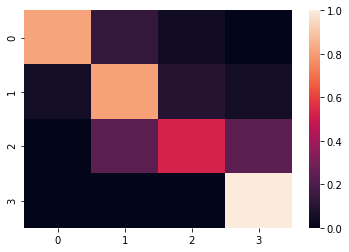

In [619]:
# print('test counts:')
# print(pd.DataFrame(tags_vals,counts))
print('')
print(classification_report(valid_tags, pred_tags))
print('')
print('Confusion matrix:')
print(cfs_with_index)
sns.heatmap(cfs_with_index_norm)
print('')

In [1219]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [1577]:

parameters = {
#     'penalty':('l1', 'l2'), 
    'C':(0.01, 0.03,0.1,0.3)
}
Grid_LR = GridSearchJK(LogisticRegression(),parameters)
Grid_LR.fit(X_train_, y_train_)

ValueError: Invalid parameter n_estimators for estimator LogisticRegression(C=0.01). Check the list of available parameters with `estimator.get_params().keys()`.

In [1562]:
y_train_.shape

(206,)

In [1253]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.770
Best parameters set:
	C: 0.3


In [1222]:
# best model
best_LR_model = Grid_LR.best_estimator_

In [1223]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,9,11,13] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13]})

In [1224]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.726
Best parameters set:
	n_neighbors: 5


In [1225]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'min_samples_split' : [2,3,4,5,6],
    'min_samples_leaf' : [1,2],
}
Grid_RF_ = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF_.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [60, 80, 100]})

In [1226]:
# best number of tress
print_grid_search_metrics(Grid_RF_)

Best score: 0.839
Best parameters set:
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 80


In [1227]:
# best random forest
best_RF_model_ = Grid_RF_.best_estimator_

In [1257]:
parameters

{'C': [0.01, 0.03, 0.1, 0.3]}

In [1259]:
parameters = {
#     'penalty':('l1', 'l2'), 
    'C':[0.01, 0.03,0.1,0.3]
}
LR = LogisticRegression()
Grid_LR_ = GridSearchJK(LR, parameters)
Grid_LR_.fit(X_train, y_train)

print_grid_search_metrics(Grid_LR_)

0.7130434782608696 {'C': 0.01}
0.7391304347826086 {'C': 0.03}
0.7739130434782608 {'C': 0.1}
Best score: 0.774
Best parameters set:
	C: 0.1


In [1243]:
predictions_ = best_RF_model_.predict(X_test)
true_labels_ = y_test

In [1244]:
eval_accuracy = accuracy_score(true_labels_, predictions_, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels_, predictions_, average='macro', beta=1)
precision = precision_score(true_labels_, predictions_, average='macro')
recall = recall_score(true_labels_, predictions_, average='macro')

print(eval_accuracy, fbeta, precision, recall)

0.8888888888888888 0.880266836709668 0.899621212121212 0.8829818111455108


In [763]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.741
precision is: 0.769
recall is: 0.714


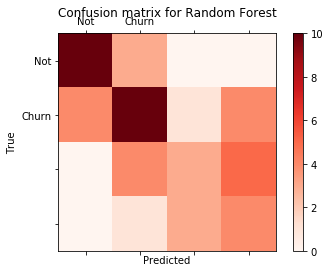

Logistic Regression
Accuracy is: 0.609
precision is: 1.000
recall is: 0.182


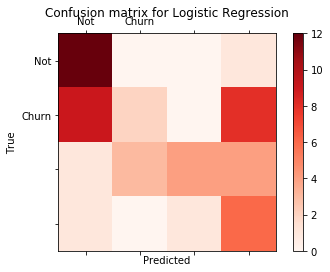

In [764]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report
from sklearn.metrics import fbeta_score, precision_recall_fscore_support

eval_accuracy = accuracy_score(true_labels, predictions, normalize=True, sample_weight=None)
fbeta = fbeta_score(true_labels, predictions, average='macro', beta=1)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')

pred_tags = [tags_vals[p] for p in predictions]
valid_tags = [tags_vals[l] for l in true_labels]
counts = [valid_tags.count(tag) for tag in tags_vals]
cfs_mat = confusion_matrix(valid_tags, pred_tags,tags_vals)
cfs_with_index = pd.DataFrame(cfs_mat, index = tags_vals,
              columns = tags_vals)
cfs_mat_norm = cfs_mat/cfs_mat.sum(axis=1, keepdims = True)
cfs_with_index_norm = pd.DataFrame(cfs_mat_norm, index = tags_vals,
              columns = tags_vals)
classification_report(valid_tags, pred_tags)

In [654]:
#Combine features and labels
data = pd.merge(features, labels, how='left', on='full_name')

In [656]:
to_drop = ['full_name','description','readme','info']
data = data.drop(to_drop, axis=1)

In [657]:
data

,size,stars,watches,forks,owner_type,if_fork,homepage,license,files,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,google,h2,links,words,book,hello,hw,Y
0,27451.0,19190.0,1906.0,7003.0,False,False,False,False,3.0,3633.0,1.0,0.0,99.0,0.0,2373.0,True,45.0,82.0,0.0,0.0,22.0,320.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0,9,55,1284,8,0,0,3
1,8034.0,26702.0,1218.0,6964.0,True,False,False,True,32.0,2584.0,6.0,78.0,40.0,6.0,2567.0,True,2436.0,2418.0,97.0,20.0,49.0,140.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,25.0,0.0,1,11,27,1197,0,0,2,1
2,6848.0,17135.0,305.0,1020.0,False,False,True,True,29.0,1323.0,16.0,11.0,112.0,0.0,2887.0,True,499.0,1169.0,60.0,22.0,89.0,385.0,19.0,12.0,34.0,5.0,7.0,11.0,63.0,51.0,0.0,0.0,45.0,0.0,575.0,0,0,15,498,0,0,0,1
3,2396.0,20383.0,430.0,1193.0,False,False,True,True,22.0,2021.0,55.0,49.0,189.0,6.0,3129.0,True,354.0,390.0,18.0,8.0,112.0,531.0,12.0,2.0,2.0,1.0,3.0,3.0,28.0,4.0,0.0,0.0,66.0,0.0,1.0,0,6,31,1039,0,0,0,1
4,8496.0,10153.0,737.0,2798.0,True,False,True,True,86.0,1697.0,5.0,96.0,156.0,0.0,6227.0,True,36.0,277.0,13.0,32.0,10.0,362.0,7.0,43.0,9.0,1.0,11.0,88.0,2864.0,1405.0,0.0,0.0,5.0,5.0,0.0,0,6,9,266,0,0,0,1
5,80841.0,13979.0,514.0,4609.0,True,False,True,True,35.0,23207.0,23.0,172.0,931.0,2.0,6752.0,True,1931.0,6672.0,324.0,354.0,257.0,7715.0,100.0,694.0,82.0,3.0,32.0,648.0,36144.0,21505.0,394799.0,23614.0,19.0,28.0,0.0,0,1,16,302,0,0,0,1
6,12127.0,13221.0,575.0,1082.0,False,False,False,False,12.0,1712.0,1.0,0.0,100.0,6.0,1929.0,True,208.0,451.0,0.0,0.0,31.0,249.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,511.0,0,12,26,1249,0,0,0,1
7,141137.0,32941.0,2191.0,19265.0,True,False,False,True,464.0,59611.0,5.0,772.0,1373.0,2.0,5546.0,False,0.0,0.0,0.0,0.0,32.0,682.0,25.0,82.0,4.0,0.0,33.0,780.0,82077.0,62162.0,0.0,0.0,7.0,17.0,0.0,0,0,5,510,0,0,0,1
8,23803.0,12243.0,392.0,1143.0,True,False,True,True,25.0,7718.0,39.0,59.0,152.0,0.0,1967.0,True,41.0,673.0,28.0,72.0,10.0,1471.0,8.0,165.0,25.0,0.0,17.0,283.0,18578.0,14330.0,0.0,0.0,125.0,168.0,0.0,0,6,24,1427,0,0,0,1
9,53431.0,7463.0,413.0,1935.0,True,False,True,True,25.0,13261.0,101.0,83.0,395.0,3.0,4243.0,True,236.0,1422.0,45.0,39.0,88.0,3794.0,28.0,102.0,16.0,2.0,9.0,242.0,7061.0,5920.0,0.0,0.0,21.0,37.0,0.0,0,8,64,2263,0,0,0,1


In [658]:
len(data.)

43

In [506]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [507]:
data[data['Y']==1]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,commits,branches,releases,contributors,topics,age,readme,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,Y
1,bilibili/ijkplayer,8034.0,26702.0,1218.0,6964.0,Organization,False,"Android/iOS video player based on FFmpeg n3.4,...",False,True,32.0,2584.0,6.0,78.0,40.0,6.0,2567.0,# ijkplayerþþ Platform | Build Statusþ -------...,True,2436.0,2418.0,97.0,20.0,49.0,140.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,25.0,0.0,NaN,1
2,stedolan/jq,6848.0,17135.0,305.0,1020.0,User,False,Command-line JSON processor,True,True,29.0,1323.0,16.0,11.0,112.0,0.0,2887.0,jqþ==þþjq is a lightweight and flexible comman...,True,499.0,1169.0,60.0,22.0,89.0,385.0,19.0,12.0,34.0,5.0,7.0,11.0,63.0,51.0,0.0,0.0,45.0,0.0,575.0,NaN,1
3,ggreer/the_silver_searcher,2396.0,20383.0,430.0,1193.0,User,False,"A code-searching tool similar to ack, but faster.",True,True,22.0,2021.0,55.0,49.0,189.0,6.0,3129.0,# The Silver SearcherþþA code searching tool s...,True,354.0,390.0,18.0,8.0,112.0,531.0,12.0,2.0,2.0,1.0,3.0,3.0,28.0,4.0,0.0,0.0,66.0,0.0,1.0,NaN,1
4,memcached/memcached,8496.0,10153.0,737.0,2798.0,Organization,False,memcached development tree,True,True,86.0,1697.0,5.0,96.0,156.0,0.0,6227.0,# MemcachedþþMemcached is a high performance m...,True,36.0,277.0,13.0,32.0,10.0,362.0,7.0,43.0,9.0,1.0,11.0,88.0,2864.0,1405.0,0.0,0.0,5.0,5.0,0.0,NaN,1
5,numpy/numpy,80841.0,13979.0,514.0,4609.0,Organization,False,The fundamental package for scientific computi...,True,True,35.0,23207.0,23.0,172.0,931.0,2.0,6752.0,"# <img alt=""NumPy"" src=""https://cdn.rawgit.com...",True,1931.0,6672.0,324.0,354.0,257.0,7715.0,100.0,694.0,82.0,3.0,32.0,648.0,36144.0,21505.0,394799.0,23614.0,19.0,28.0,0.0,NaN,1
6,vurtun/nuklear,12127.0,13221.0,575.0,1082.0,User,False,A single-header ANSI C gui library,False,False,12.0,1712.0,1.0,0.0,100.0,6.0,1929.0,# Nuklearþþ## ALL DEVELOPMENT MOVED ELSEWHEREþ...,True,208.0,451.0,0.0,0.0,31.0,249.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,511.0,NaN,1
7,git/git,141137.0,32941.0,2191.0,19265.0,Organization,False,Git Source Code Mirror - This is a publish-onl...,False,True,464.0,59611.0,5.0,772.0,1373.0,2.0,5546.0,[![Build status](https://github.com/git/git/wo...,False,0.0,0.0,0.0,0.0,32.0,682.0,25.0,82.0,4.0,0.0,33.0,780.0,82077.0,62162.0,0.0,0.0,7.0,17.0,0.0,NaN,1
8,facebook/zstd,23803.0,12243.0,392.0,1143.0,Organization,False,Zstandard - Fast real-time compression algorithm,True,True,25.0,7718.0,39.0,59.0,152.0,0.0,1967.0,"<p align=""center""><img src=""https://raw.github...",True,41.0,673.0,28.0,72.0,10.0,1471.0,8.0,165.0,25.0,0.0,17.0,283.0,18578.0,14330.0,0.0,0.0,125.0,168.0,0.0,NaN,1
9,libgit2/libgit2,53431.0,7463.0,413.0,1935.0,Organization,False,"A cross-platform, linkable library implementat...",True,True,25.0,13261.0,101.0,83.0,395.0,3.0,4243.0,libgit2 - the Git linkable libraryþ===========...,True,236.0,1422.0,45.0,39.0,88.0,3794.0,28.0,102.0,16.0,2.0,9.0,242.0,7061.0,5920.0,0.0,0.0,21.0,37.0,0.0,NaN,1
10,irungentoo/toxcore,10353.0,8601.0,598.0,1246.0,User,False,The future of online communications.,True,True,24.0,3771.0,2.0,1.0,155.0,2.0,2546.0,![Project Tox](https://raw.github.com/irungent...,True,94.0,551.0,0.0,0.0,7.0,931.0,0.0,1.0,25.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,437.0,NaN,1


In [508]:
data[data['Y']==2]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,commits,branches,releases,contributors,topics,age,readme,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,Y
32,robotmedia/RMStore,11667.0,2350.0,92.0,443.0,Organization,False,A lightweight iOS library for In-App Purchases,False,True,10.0,354.0,1.0,13.0,16.0,0.0,2510.0,#RMStoreþþ[![CocoaPods Version](https://cocoap...,True,68.0,105.0,1.0,0.0,24.0,35.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,1.0,0.0,NaN,2
33,msysgit/msysgit,225005.0,1866.0,226.0,634.0,Organization,False,msysGit has been superseded by Git for Windows...,True,False,22.0,1245.0,27.0,71.0,58.0,0.0,4695.0,# Please note!þþGit for Windows 1.x was retire...,True,0.0,209.0,0.0,0.0,0.0,123.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,NaN,2
35,madler/zlib,3753.0,2464.0,161.0,1380.0,User,False,A massively spiffy yet delicately unobtrusive ...,True,False,57.0,419.0,2.0,72.0,17.0,0.0,3199.0,ZLIB DATA COMPRESSION LIBRARYþþzlib 1.2.11 is ...,True,96.0,122.0,21.0,6.0,147.0,137.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,351.0,NaN,2
38,ms-iot/samples,295111.0,1210.0,298.0,1443.0,Organization,False,Windows 10 IoT Core Samples,False,True,67.0,1657.0,7.0,4.0,58.0,0.0,1872.0,Windows 10 IoT Core Samplesþ==============þþ##...,True,23.0,128.0,0.0,0.0,5.0,390.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,5.0,0.0,NaN,2
42,lloyd/yajl,2095.0,1945.0,94.0,391.0,User,False,A fast streaming JSON parsing library in C.,True,True,16.0,275.0,9.0,20.0,20.0,0.0,4715.0,**********************************************...,True,72.0,43.0,2.0,0.0,76.0,37.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,0.0,568.0,NaN,2
48,Qihoo360/phptrace,1704.0,1620.0,158.0,403.0,Organization,False,A tracing and troubleshooting tool for PHP scr...,False,True,14.0,502.0,1.0,7.0,10.0,0.0,2026.0,# phptraceþþ> We have a new trace tool **[Molt...,True,26.0,63.0,3.0,0.0,0.0,17.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,7.0,0.0,NaN,2
50,vlfeat/vlfeat,10399.0,1315.0,158.0,580.0,Organization,False,An open library of computer vision algorithms,True,True,16.0,2059.0,2.0,26.0,18.0,0.0,4734.0,# VLFeat -- Vision Lab Features Libraryþþ> Ver...,True,103.0,52.0,1.0,1.0,25.0,30.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,2
58,sgminer-dev/sgminer,16123.0,565.0,129.0,854.0,Organization,False,Scrypt GPU miner,False,True,69.0,6498.0,6.0,13.0,84.0,0.0,3489.0,# sgminerþþþ## IntroductionþþThis is a multi-t...,True,137.0,244.0,0.0,1.0,17.0,107.0,0.0,0.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,2
59,haproxy-unofficial-obsolete-mirrors/haproxy,19218.0,919.0,98.0,317.0,Organization,False,UNOFFICIAL fork of haproxy development reposit...,True,True,20.0,6096.0,1.0,196.0,120.0,0.0,5292.0,---------------------...,False,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,NaN,2
60,cesanta/v7,19733.0,1249.0,93.0,160.0,Organization,False,Embedded JavaScript engine for C/C++,False,True,10.0,1911.0,7.0,3.0,17.0,0.0,2374.0,V7: Embedded JavaScript engineþ===============...,True,48.0,103.0,0.0,0.0,2.0,436.0,0.0,0.0,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,1.0,0.0,NaN,2


In [1372]:
data[data['Y']==3]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
4,julycoding/The-Art-Of-Programming-By-July,27451,19203,1907,7003,False,False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,False,,3,C,"{'': 1, 'md': 1}",3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,0,4,0,4,NaN,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,3.0,,0,9,55,1286,0,0
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
134,enchev/ios-ng2-tns,24996,5,0,0,False,False,,False,,7,C,"{'': 1, 'md': 1}",2,1,0,1,0,1292,True,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,10,0,59,NaN,Read more about this app here: https://medium....,3.0,,0,0,3,42,0,0
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
139,stijnmeul/thesis,358681,1,2,0,False,False,Identity-based encryption for online social ne...,False,,13,C,"{'md': 2, '': 1}",157,1,0,1,0,2306,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,4,0,1,NaN,Practical Identity-based encryption for Online...,3.0,,0,0,2,502,0,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
141,AdnanHaiderAD/MSc-Dissertation,2070000,0,1,0,False,False,,False,,22,C,"{'pdf': 1, '': 3, 'md': 1, 'txt': 2, 'm~': 1, ...",258,1,0,1,0,2634,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,19,0,2,NaN,MSc-Dissertationþ================,3.0,,0,0,0,4,0,0
144,Jesse-V/RLAGS-USU,343053,2,3,0,False,False,RLAG Sensor - Space Dynamics Laboratory,False,,16,C,"{'': 3, 'txt~': 1, 'tar': 2, 'gz': 1, 'desktop...",104,1,0,2,0,2211,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,35,0,56,NaN,,3.0,,0,0,0,7,0,0
147,lisider/my_book,536042,22,5,21,False,False,喜欢的技术书籍,False,,5,C,{'pdf': 1},8,1,0,1,0,777,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,50,0,4,NaN,,3.0,,0,0,0,3,0,0


In [1371]:
data[(( (data['hw']>0)) & (data['Y']>=3)]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
148,lianhongHou/books,1521857,0,1,0,False,False,,False,,9,C,{'pdf': 1},26,1,0,1,0,1713,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,12,0,0,NaN,,3.0,,0,0,0,2,1,0
151,tgut/books,586483,1,1,2,False,False,useful book on programming,False,,15,NaN,"{'': 1, 'md': 1}",11,1,0,1,0,471,True,0,0,0,0,0,0,0,0,8,0,1,3,0,0,0,0,10,0,0,NaN,# booksþsome books on computer programmingþthe...,3.0,,0,0,0,39,4,0
156,isislovecruft/library--,1886220,396,38,58,False,False,The papers and books I've read or am about to ...,False,,32,C,"{'': 1, 'rst': 1}",1974,1,0,2,0,2092,True,0,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0,160,0,1,NaN,================þ Libraryþ================þþTh...,3.0,,0,4,4,185,1,0
158,Leon555/Books-Programming,761708,5,2,5,False,False,"repo for OS-related books like linux, network,...",False,,11,C,{},1,1,0,1,0,1880,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,40,0,9,NaN,,3.0,,0,0,0,11,1,0
160,K0-0K/book,3508136,8,4,68,True,False,book,False,,65,C,"{'': 2, 'md': 1}",25,1,0,1,0,2556,False,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,9,0,0,NaN,bookþ====þþbook,3.0,,0,0,0,5,2,0
197,CPTS224/HW4,304,0,0,3,True,False,,False,,3,C,"{'c': 2, 'h': 1}",1,1,0,1,0,957,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,9,0,0,NaN,,4.0,,0,0,0,2,0,1


In [1366]:
(data['book']>0)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64       True
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [1379]:
data[(data['hw']>0) &(data['Y']>=3) ]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
197,CPTS224/HW4,304,0,0,3,True,False,,False,,3,C,"{'c': 2, 'h': 1}",1,1,0,1,0,957,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,9,0,0,NaN,,4.0,,0,0,0,2,0,1


In [1381]:
data[data['Y']==3]

,full_name,size,stars,watches,forks,owner_type,if_fork,description,homepage,license,files,language,formats,commits,branches,releases,contributors,topics,age,has_issues,open_issues,closed_issues,open_issues_recent,closed_issues_recent,open_prs,closed_prs,open_prs_recent,closed_prs_recent,labels,milestones,recent_contributors,recent_commits,recent_added,recent_deleted,dependent_repositories,dependent_packages,repositories,people,followers,info,readme,Y,license_key,google,h2,links,words,book,hw
4,julycoding/The-Art-Of-Programming-By-July,27451,19203,1907,7003,False,False,本项目曾冲到全球第一，干货集锦见本页面最底部，另完整精致的纸质版《编程之法：面试和算法心得》...,False,,3,C,"{'': 1, 'md': 1}",3633,1,0,99,0,2376,True,45,82,0,0,22,320,1,0,6,0,0,0,0,0,0,0,4,0,4,NaN,## Aboutþþ**July的新书《编程之法：面试和算法心得》纸质版在本github上的...,3.0,,0,9,55,1286,0,0
104,SamyPesse/How-to-Make-a-Computer-Operating-System,5986,18806,1671,3270,False,False,How to Make a Computer Operating System in C++,True,"{'key': 'apache-2.0', 'name': 'Apache License ...",17,C,"{'': 2, 'md': 2, 'jpg': 2, 'png': 1}",243,1,12,34,0,2391,True,38,25,1,0,37,54,1,0,6,1,0,0,0,0,0,0,86,0,2,NaN,How to Make a Computer Operating Systemþ======...,3.0,apache-2.0,0,1,7,272,2,0
128,XPila/HW,80,0,1,0,False,False,Hardware Library,False,,4,C,{'md': 1},44,1,0,1,0,1663,True,3,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,20,0,1,NaN,# HWþHardware Libraryþtestþtest2,3.0,,0,0,0,9,0,2
134,enchev/ios-ng2-tns,24996,5,0,0,False,False,,False,,7,C,"{'': 1, 'md': 1}",2,1,0,1,0,1292,True,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,10,0,59,NaN,Read more about this app here: https://medium....,3.0,,0,0,3,42,0,0
138,yubaoliu/Library,1623614,0,1,0,False,False,"book, ppt, pdf resources for Software Development",False,,18,C,"{'': 1, 'md': 1}",3,1,0,1,0,873,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,102,0,10,NaN,"# Libraryþbook, ppt, pdf resources for Softwar...",3.0,,0,0,0,17,2,0
139,stijnmeul/thesis,358681,1,2,0,False,False,Identity-based encryption for online social ne...,False,,13,C,"{'md': 2, '': 1}",157,1,0,1,0,2306,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,4,0,1,NaN,Practical Identity-based encryption for Online...,3.0,,0,0,2,502,0,0
140,LSayhi/book-paper-note,591903,50,6,19,False,False,books papers notes,False,,13,Jupyter Notebook,"{'pdf': 10, 'txt': 1, 'zip': 1}",27,1,0,1,0,867,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,18,0,28,NaN,"Books,papers,notes for computer science and da...",3.0,,0,0,0,14,2,0
141,AdnanHaiderAD/MSc-Dissertation,2070000,0,1,0,False,False,,False,,22,C,"{'pdf': 1, '': 3, 'md': 1, 'txt': 2, 'm~': 1, ...",258,1,0,1,0,2634,True,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,19,0,2,NaN,MSc-Dissertationþ================,3.0,,0,0,0,4,0,0
144,Jesse-V/RLAGS-USU,343053,2,3,0,False,False,RLAG Sensor - Space Dynamics Laboratory,False,,16,C,"{'': 3, 'txt~': 1, 'tar': 2, 'gz': 1, 'desktop...",104,1,0,2,0,2211,True,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,35,0,56,NaN,,3.0,,0,0,0,7,0,0
147,lisider/my_book,536042,22,5,21,False,False,喜欢的技术书籍,False,,5,C,{'pdf': 1},8,1,0,1,0,777,True,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,50,0,4,NaN,,3.0,,0,0,0,3,0,0


In [1369]:
(data['book']>0) | (data['hw']>0) & (data['Y']==3)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21       True
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64       True
65      False
66      False
67      False
68      False
69      False
70      False
71    